# Making Decorrelation and Topic Selection Friends

ARTM library makes it possible to modify topic model training procedure by introducing *regularizers*: additional terms that reduce possible number of solutions in the equation being optimized.
Final topic model is more likely to have some desirable properties, imposed by the regularizers.

There are a couple of particulalry useful regularizers, which are recommended to use in almost any case, one of these is [Decorrelator Phi](https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html#decorrelator-phi).
There is also one: [Topic Selection Theta](https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html#topic-selection-theta) — which may help in finding the number of topics in the dataset.
However, these two may have a negative effect on each other if being used at the same time (one may see [paper](https://userpages.umbc.edu/~kogan/teaching/m710/15fall/papers/Voron15slds.pdf)).

The ultimate goal of this notebook is to show how, using TopicNet functionality, one can conveniently combine regularizers in different (sometimes quite nontrivial) ways.
Regularizers chosen for demonstration are mentioned Decorrelator Phi & Topic Selection Theta: finding best combination strategy is especially relevant in this case.

In [ ]:
# General

from collections import Counter
from datetime import datetime
from functools import reduce
from itertools import combinations
import json
import numpy as np
import os
import pandas as pd
import re
import shutil
import tempfile


# Data

from sklearn.datasets import fetch_20newsgroups


# Plots

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline


# NLP

import artm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.cubes import RegularizationControllerCube
from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.models import BaseScore
from topicnet.cooking_machine.models import TopicModel
from topicnet.cooking_machine.model_constructor import add_standard_scores

In [ ]:
ENGLISH_STOPWORDS = set(stopwords.words('english'))
ENGLISH_LEMMATIZER = WordNetLemmatizer()

ARTM and TopicNet versions.
Ideally, the notebook should work with any newer versions of the libraries, but still there is a possibility that some minor details may become outdated.

P.S.  
Some warning were manually deleted from the notebook, so as not to distract attention

In [ ]:
print('ARTM version:', artm.version())
print('TopicNet release: v0.5.0')

ARTM version: 0.10.0
TopicNet release: v0.5.0


Link to TopicNet release that was used in the notebook:  
https://github.com/machine-intelligence-laboratory/TopicNet/releases/tag/v0.5.0

Default font size in plots

In [ ]:
plt.rcParams['font.size']

10.0

We make it bigger

In [ ]:
plt.rcParams.update({'font.size': 20})

The notebook appeared way bigger than expected: a huge part is devoted to data explorations and preparation, and constructing custom topic model scores.

# Contents<a id="contents"></a>

* [Dataset](#dataset)
    * [Basic Study](#basic-study)
    * [Preprocessing](#preprocessing)
* [TopicNet](#topicnet)
    * [Data Preparation](#topicnet-data-preparation)
        * [Vowpal Wabbit](#vowpal-wabbit)
        * [Cooccurrences](#cooccurrences)
    * [Model Initialization](#model-initialization)
    * [Fixing Regularizer Parameters](#fixing-regularizers)
        * [Decorrelation](#fixing-decorrelation)
        * [Topic Selection](#fixing-topic-selection)
        * [Sparsing](#fixing-sparsing)
        * [Best Parameters](#best-parameters)
    * [Combining Regularizers in Different Ways](#combining-regularizers)
        * [Decorrelation, Topic Selection](#decorr-select)
        * [Topic Selection, Decorrelation](#select-decorr)
        * [Decorrelation with Topic Selection (Short)](#decorr-with-select-short)
        * [Decorrelation with Topic Selection (Long)](#decorr-with-select-long)
        * [Sophisticated. All at Once but One after Another](#sophisticated-one-after-another)
        * [Sophisticated. Changing Parameters](#sophisticated-changing)
        * [Sophisticated. Alternating Order](#sophisticated-alternating)
        * [Sophisticated. Alternating Order & Changing Parameters](#sophisticated-alternating-and-changing)
* [Results](#results)
* [Conclusion](#conclusion)
* [Appendix. Non-Topic Modeling Baseline](#appendix1-non-topic)

# Dataset<a id="dataset"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Loading full train and test data

In [ ]:
full_train_dataset = fetch_20newsgroups(
    subset='train',
    random_state=42
)
full_test_dataset = fetch_20newsgroups(
    subset='test',
    random_state=42
)

Loading reduced versions without meta data (eg. headers, footers), so as to train models on just plain text.

In [ ]:
train_dataset = fetch_20newsgroups(
    subset='train',
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)
test_dataset = fetch_20newsgroups(
    subset='test',
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)

There are 20 topics in the dataset, some are closely related to each other.

In [ ]:
train_dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Texts are arranged in list

In [ ]:
type(train_dataset.data)

list

Let's look at one piece of text from train data

In [ ]:
print(train_dataset.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


Targets are encoded known text topics

In [ ]:
train_dataset.target[:5]

array([ 7,  4,  4,  1, 14])

## Basic Study<a id="basic-study"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

How many documents are there in train and test datasets?

In [ ]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 10 ** 6

train_dataset_size_mb = size_mb(train_dataset.data)
test_dataset_size_mb = size_mb(test_dataset.data)

print(f'{len(train_dataset.data):5d} documents,  {train_dataset_size_mb:7.3f} MB (train)')
print(f'{len(test_dataset.data):5d} documents,  {test_dataset_size_mb:7.3f} MB (test)')

11314 documents,   13.782 MB (train)
 7532 documents,    8.262 MB (test)


How many documents are in each topic?

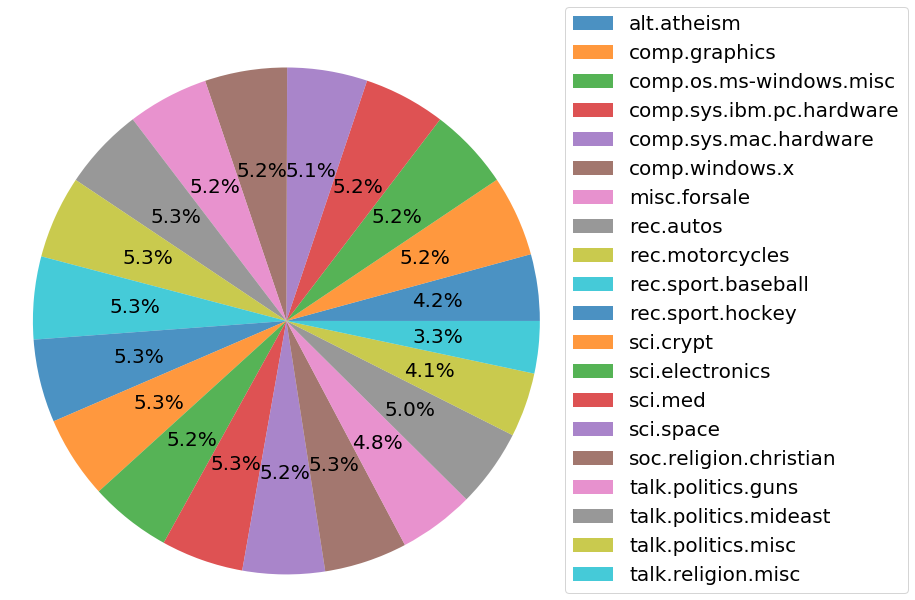

In [ ]:
figure = plt.figure(figsize=(10, 10))

targets, sizes = np.unique(train_dataset.target, return_counts=True)
target_names = [train_dataset.target_names[i] for i in targets]

patches, _, _ = plt.pie(sizes, autopct='%1.1f%%', wedgeprops={'alpha': 0.8})

plt.legend(patches, target_names, loc=(1, 0.0))

plt.axis('equal')
plt.show()

Topics have roughly the same number of documents

It might also be useful to look at some language statistical properties: words distribution, document lengths distribution.
Below are just some functions for analyzing texts.

In [ ]:
COLOR = (176/255, 0, 0)
FIGSIZE = (15, 10)
SMALL_FIGSIZE = (10, 6)
LINEWIDTH = 5
LABELPAD = 10


# https://en.wikipedia.org/wiki/Zipf%27s_law

def draw_zipfs_plot(
        texts,
        low_outlier_percentile_bound=1,
        upper_outlier_percentile_bound=99,
        ax=None):

    counter = Counter(' '.join(texts).split())
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    else:
        fig = None
    
    frequencies = [freq for word, freq in counter.most_common()]
    low_outlier_bound = np.percentile(frequencies, low_outlier_percentile_bound)
    upper_outlier_bound = np.percentile(frequencies, upper_outlier_percentile_bound)
    frequencies = [freq for freq in frequencies if freq > low_outlier_bound and freq <= upper_outlier_bound]
    
    ranks = range(1, len(frequencies) + 1)
    
    ax.plot(ranks, frequencies, lw=LINEWIDTH, color=COLOR)
    
    ax.set_xlabel('Rank', labelpad=LABELPAD)
    ax.set_ylabel('Frequency', labelpad=LABELPAD)
    ax.set_title('Zipf\'s law')
    
    if fig is not None:
        plt.show()

    return ax


# https://en.wikipedia.org/wiki/Heaps%27_law

def draw_heaps_plot(
        texts,
        in_symbols=True,
        ax=None):

    if in_symbols is True:
        lengths = [len(t) for t in texts]
        length_units = 'symbols'
    else:
        lengths = [len(t.split()) for t in texts]
        length_units = 'words'

    num_uniques = [len(set(t.split())) for t in texts]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    else:
        fig = None
    
    ax.scatter(lengths, num_uniques, s=4 * LINEWIDTH ** 2, color=COLOR)
    
    ax.set_xlabel(f'Document length ({length_units})', labelpad=LABELPAD)
    ax.set_ylabel('Number of unique tokens', labelpad=LABELPAD)
    ax.set_title('Heaps\' law')
    
    if fig is not None:
        plt.show()

    return ax


def draw_document_lengths_histogram(
        texts,
        in_symbols=False,
        low_outlier_percentile_bound=1,
        upper_outlier_percentile_bound=99,
        bins=200,
        ax=None):

    if in_symbols is True:
        lengths = [len(t) for t in texts]
        length_units = 'symbols'
    else:
        lengths = [len(t.split()) for t in texts]
        length_units = 'words'

    low_outlier_bound = np.percentile(lengths, low_outlier_percentile_bound)
    upper_outlier_bound = np.percentile(lengths, upper_outlier_percentile_bound)
    lengths = [l for l in lengths if l > low_outlier_bound and l <= upper_outlier_bound]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    else:
        fig = None
    
    ax.hist(lengths, bins=bins, color=COLOR)
    
    ax.set_xlabel(f'Document length ({length_units})', labelpad=LABELPAD)
    ax.set_ylabel('Number of documents', labelpad=LABELPAD)
    ax.set_title('Document lengths distribution')
    
    if fig is not None:
        plt.show()

    return ax

Analyzing train dataset

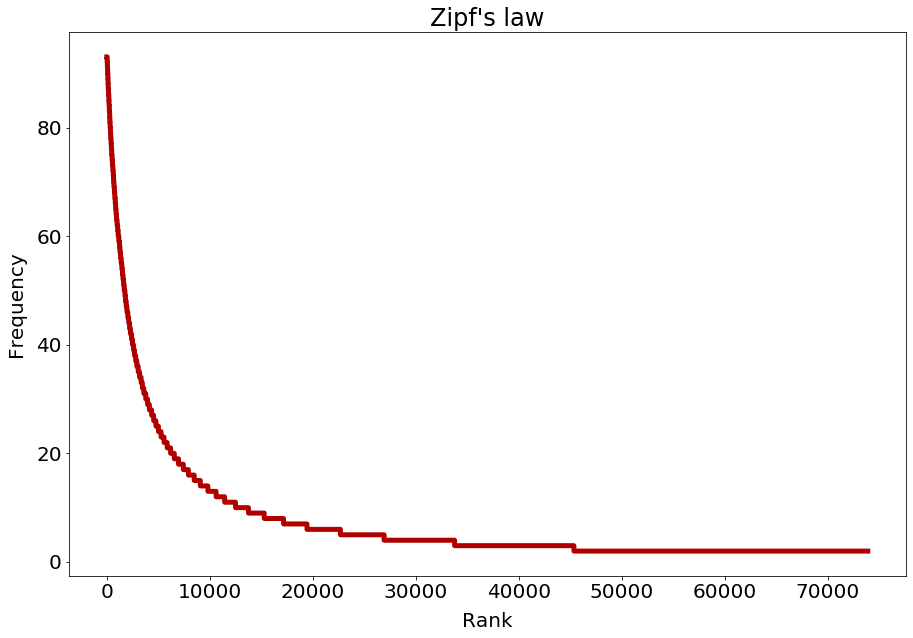

In [ ]:
draw_zipfs_plot(train_dataset.data)

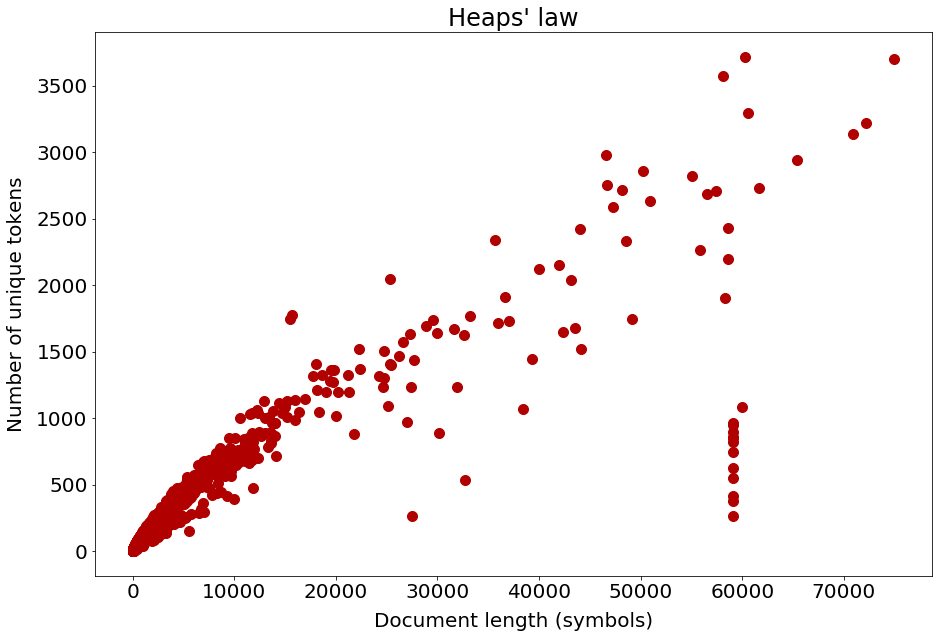

In [ ]:
draw_heaps_plot(train_dataset.data)

There is a noticeable drop out of the general trend (near document length = 60.000)...

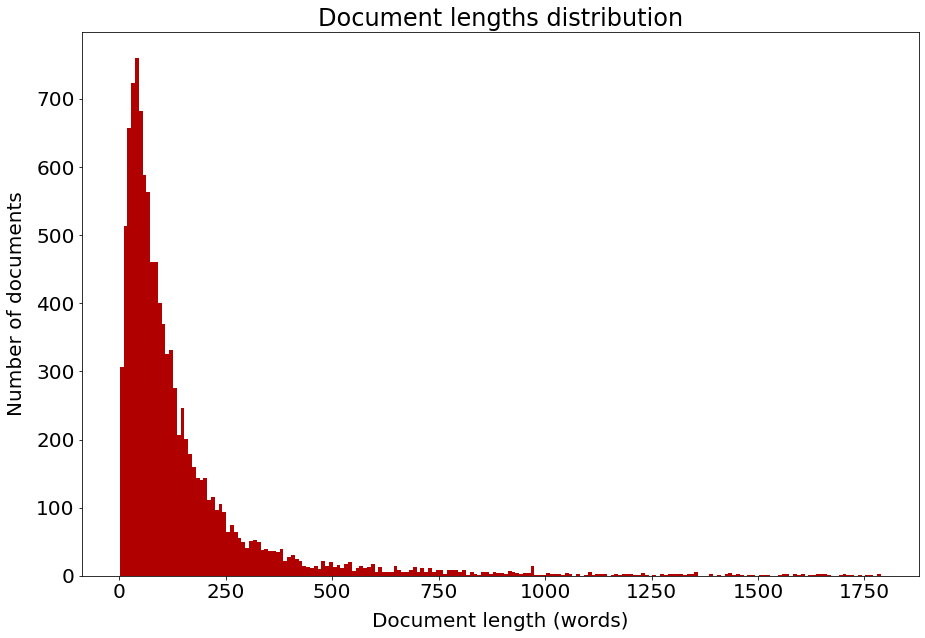

In [ ]:
draw_document_lengths_histogram(train_dataset.data)

Let's look if there are some special documents in case of lengths: too short or too long

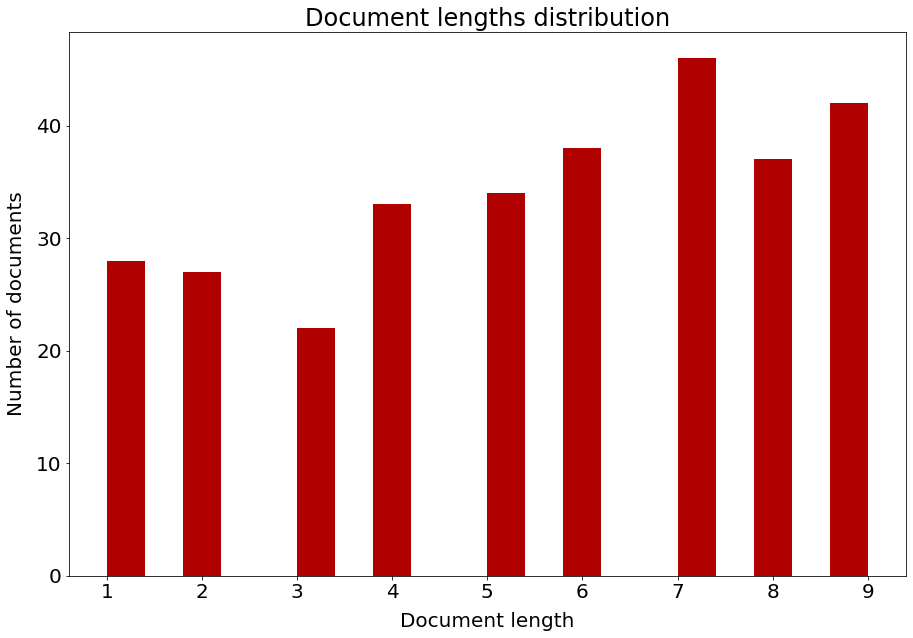

In [ ]:
draw_document_lengths_histogram(
    train_dataset.data,
    low_outlier_percentile_bound=0,
    upper_outlier_percentile_bound=5,
    bins=20
)

In [ ]:
suspiciously_short_texts = [
    t for t in train_dataset.data
    if len(t.split()) <= 9
]

In [ ]:
len(suspiciously_short_texts)

In [ ]:
print(suspiciously_short_texts[11])

Thus, most texts that are too short contain little information.

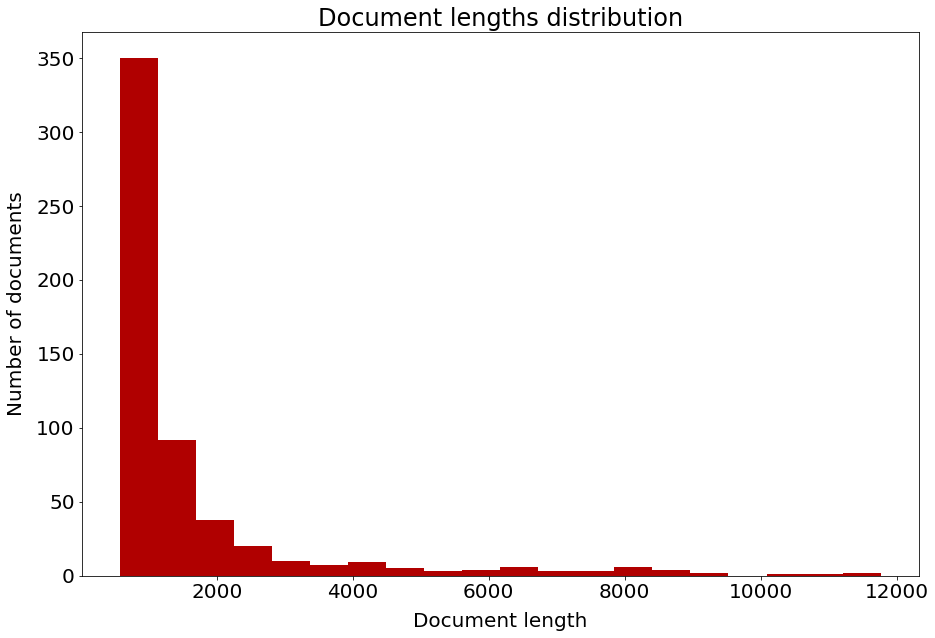

In [ ]:
draw_document_lengths_histogram(
    train_dataset.data,
    low_outlier_percentile_bound=95,
    upper_outlier_percentile_bound=100,
    bins=20
)

In [ ]:
suspiciously_long_texts = [
    t for t in train_dataset.data
    if len(t.split()) >= 2000
]

In [ ]:
len(suspiciously_long_texts)

In [ ]:
print(suspiciously_long_texts[0][:1000])

So, there are some very long documents.
Some of them contain excerpts from other books.

And here is a more compact version, combining all the three mentioned plots

In [ ]:
def draw_statistics(texts, figsize=(20, 15), font_size=16):
    old_font_size = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': font_size})

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    draw_zipfs_plot(
        texts,
        ax=axes[0][0]
    )
    draw_document_lengths_histogram(
        texts,
        ax=axes[0][1]
    )
    draw_heaps_plot(
        texts,
        ax=axes[1][0],
        in_symbols=True
    )
    draw_heaps_plot(
        texts,
        ax=axes[1][1],
        in_symbols=False
    )
    
    plt.show()
    
    plt.rcParams.update({'font.size': old_font_size})

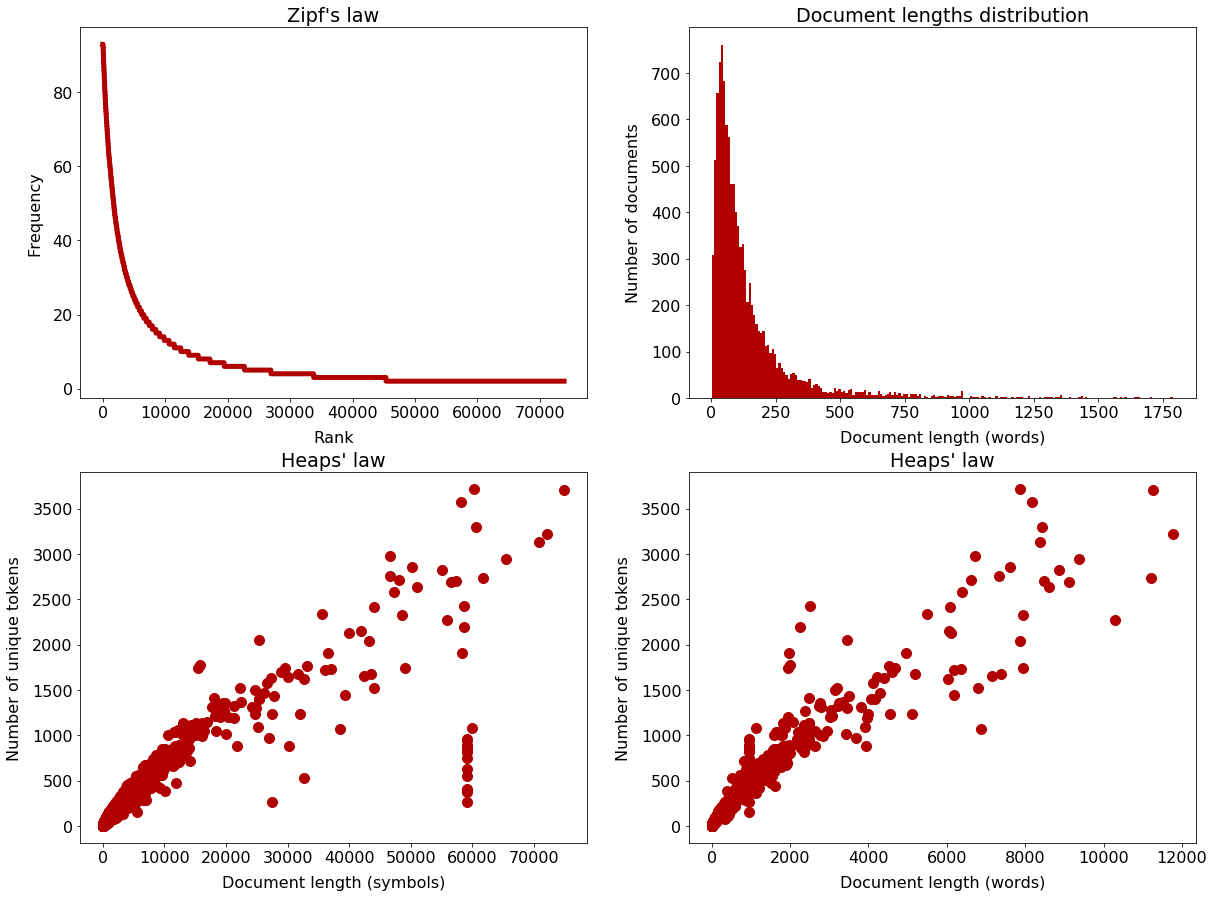

In [ ]:
draw_statistics(train_dataset.data)

Let's look at the test part of the dataset

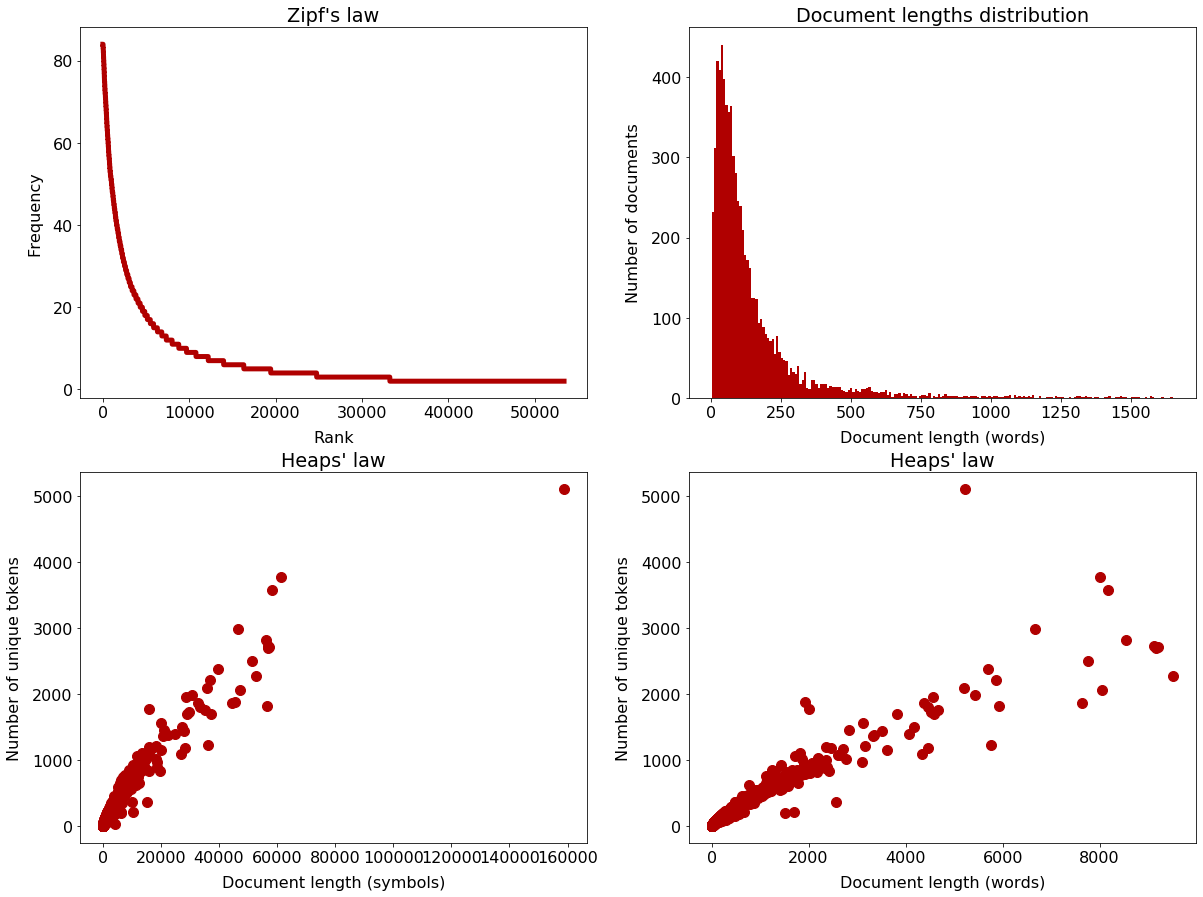

In [ ]:
draw_statistics(test_dataset.data)

One document from test dataset has a lot of unique tokens inside...

In [ ]:
interesting_document_index = np.argmax([len(set(t.split())) for t in test_dataset.data])

2015

In [ ]:
interesting_document_index

In [ ]:
len(set(test_dataset.data[interesting_document_index].split()))

5103

In [ ]:
print(full_test_dataset.data[interesting_document_index][:5000])

From: dbushong@wang.com (Dave Bushong)
Subject: Re: More Cool BMP files??
Organization: Wang Labs, Lowell MA, USA
Distribution: usa
Lines: 2603

adair@atldbs.dbsoftware.com (Owen Adair) writes:

>In article <1993Apr20.173506.2288@dlss2> james@dlss2 (James Cummings) writes:
>>Newsgroups: comp.os.ms-windows.misc
>>Path: atldbs!uupsi!psinntp!uunet!gatech!howland.reston.ans.net!bogus.sura.net!darwin.sura.net!convex!seas.smu.edu!void!dalnet!dlss2!james
>>From: james@dlss2 (James Cummings)
>>Subject: Re: More Cool BMP files??
>>Message-ID: <1993Apr20.173506.2288@dlss2>
>>Organization: RedRock Development
>>References: <1993Apr17.023017.17301@gmuvax2.gmu.edu>
>>Distribution: usa
>>Date: Tue, 20 Apr 1993 17:35:06 GMT
>>Lines: 1021
>>In article <1993Apr17.023017.17301@gmuvax2.gmu.edu> rwang@gmuvax2.gmu.edu (John Wang) writes:
>> |Hi, everybody:
>> |    I guess my subject has said it all.  It is getting boring
>> |looking at those same old bmp files that came with Windows.  So,
>> |I am wonderin

If we decode this uuencoded file, we get an archive with the following picture inside...

![BUTT](https://raw.githubusercontent.com/Alvant/20-newsgroups-secrets/master/secrets/images/BUTT/BUTT.jpg)

This one and a couple of other such findings can be viewed [here](https://github.com/Alvant/20-newsgroups-secrets) on github

## Preprocessing<a id="preprocessing"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Texts need to be prepared before training models.
Below is a function which removes all symbols except letters from texts, splits text on single tokens and also removes stopwords.
It also lemmatizes all words, i.e. replaces all words with their base forms.
In the end, it combines the remaining words together to form a piece of text.

In [ ]:
def preprocess_texts(texts):
    preprocessed_texts = list()
    
    for text in texts:
        text = text.lower()
        
        text = re.sub('[^\\w\\s]', ' ', text)
        text = re.sub('\\d+', ' ', text)
        text = re.sub('\\s+', ' ', text)
        
        words = text.split()
        
        words = [w for w in words if w not in ENGLISH_STOPWORDS]
        words = [ENGLISH_LEMMATIZER.lemmatize(w) for w in words]
        
        text = ' '.join(words)
        
        preprocessed_texts.append(text)
    
    return preprocessed_texts

In [ ]:
%%time

preprocessed_train_texts = preprocess_texts(train_dataset.data)

CPU times: user 7.23 s, sys: 310 ms, total: 7.54 s
Wall time: 6.71 s


Let's compare an original piece of text, its reduced version (without meta information) and its preprocessed version

In [ ]:
print(full_train_dataset.data[0])

print('\n' + '*' * 12 + '\n')

print(train_dataset.data[0])

print('\n' + '*' * 12 + '\n')

print(preprocessed_train_texts[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----






************

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from t

Text size decreased sharply!

In [ ]:
%%time

preprocessed_test_texts = preprocess_texts(test_dataset.data)

CPU times: user 3.27 s, sys: 65.1 ms, total: 3.34 s
Wall time: 2.96 s


And same thing for one document from test

In [ ]:
print(full_test_dataset.data[0])

print('\n' + '*' * 12 + '\n')

print(test_dataset.data[0])

print('\n' + '*' * 12 + '\n')

print(preprocessed_test_texts[0])

From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. GANDLER)
Subject: Need info on 88-89 Bonneville
Organization: University at Buffalo
Lines: 10
News-Software: VAX/VMS VNEWS 1.41
Nntp-Posting-Host: ubvmsd.cc.buffalo.edu


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler


************

I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than boo

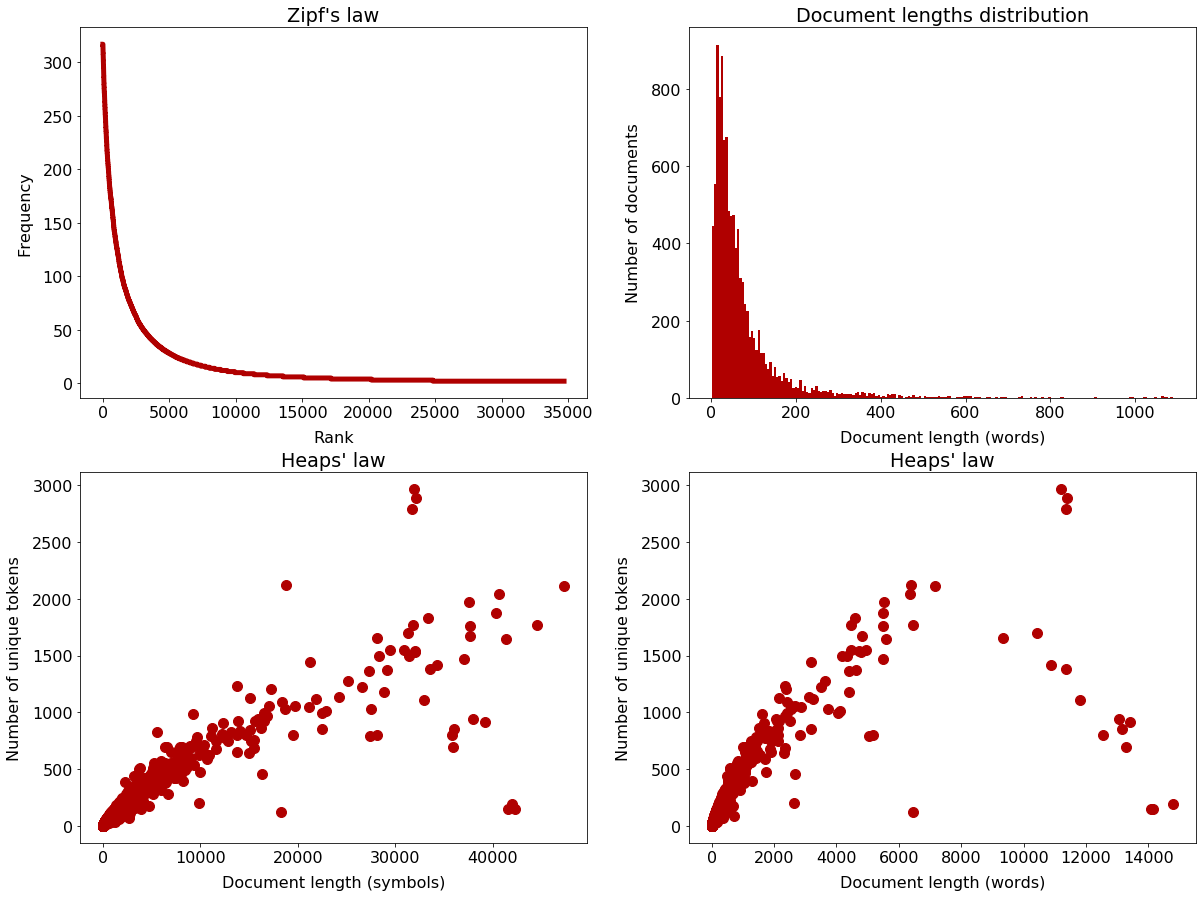

In [ ]:
draw_statistics(preprocessed_train_texts)

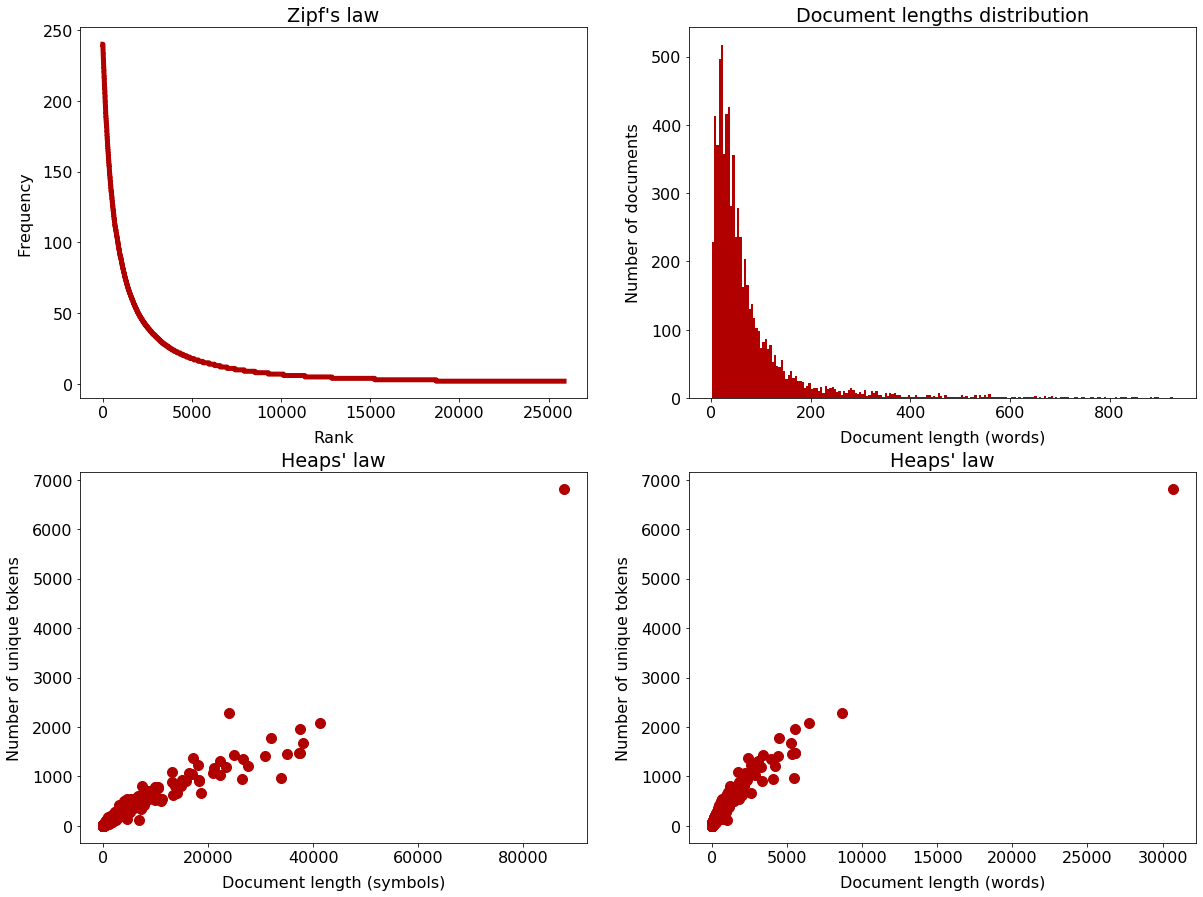

In [ ]:
draw_statistics(preprocessed_test_texts)

There are still points, in both train and test parts, that fall out of the empirical dependence suggested by Heaps' law. Let's try to filter the vocabulary according to the word frequency statistics.

In [ ]:
vocabulary = reduce(
    lambda res, cur: res.union(set(cur.split())),
    preprocessed_train_texts,
    set()
)

The initial size of the vocabulary

In [ ]:
len(vocabulary)

69739

In [ ]:
%%time

# How many times did the word occur in the collection

term_frequency_counter = Counter(
    ' '.join(preprocessed_train_texts).split()
)

# How many documents of the collection did the word occur in

document_frequency_counter = Counter(
    ' '.join(
        [' '.join(set(t.split())) for t in preprocessed_train_texts]
    ).split()
)

CPU times: user 722 ms, sys: 0 ns, total: 722 ms
Wall time: 638 ms


Let's look at the most/least common words concerning frequency

In [ ]:
term_frequency_counter.most_common(20)

[('ax', 62505),
 ('x', 9913),
 ('u', 8189),
 ('q', 7998),
 ('w', 7590),
 ('one', 6767),
 ('f', 6751),
 ('g', 6609),
 ('v', 6383),
 ('p', 6263),
 ('would', 6163),
 ('b', 6102),
 ('r', 6100),
 ('c', 5389),
 ('e', 4637),
 ('max', 4600),
 ('n', 4307),
 ('people', 4135),
 ('l', 4073),
 ('k', 4019)]

In [ ]:
term_frequency_counter.most_common()[::-1][:20]

[('willow', 1),
 ('equi', 1),
 ('ebodin', 1),
 ('bodin', 1),
 ('jiggling', 1),
 ('aneurysm', 1),
 ('hemicrania', 1),
 ('paroxysmal', 1),
 ('intracranial', 1),
 ('sured', 1),
 ('ofthe', 1),
 ('kneecap', 1),
 ('alesis', 1),
 ('fraternatae', 1),
 ('egalitae', 1),
 ('libertae', 1),
 ('clawed', 1),
 ('swam', 1),
 ('incidently', 1),
 ('laussane', 1)]

In [ ]:
document_frequency_counter.most_common(20)

[('one', 3299),
 ('would', 3168),
 ('like', 2564),
 ('know', 2413),
 ('get', 2338),
 ('time', 2023),
 ('also', 1947),
 ('think', 1930),
 ('people', 1827),
 ('make', 1706),
 ('could', 1682),
 ('use', 1649),
 ('well', 1620),
 ('good', 1591),
 ('way', 1504),
 ('even', 1501),
 ('thing', 1475),
 ('year', 1467),
 ('much', 1457),
 ('say', 1438)]

In [ ]:
document_frequency_counter.most_common()[::-1][:20]

[('willow', 1),
 ('equi', 1),
 ('jiggling', 1),
 ('bodin', 1),
 ('ebodin', 1),
 ('millie', 1),
 ('paroxysmal', 1),
 ('hemicrania', 1),
 ('intracranial', 1),
 ('aneurysm', 1),
 ('sured', 1),
 ('ofthe', 1),
 ('kneecap', 1),
 ('alesis', 1),
 ('grudgingly', 1),
 ('egalitae', 1),
 ('clawed', 1),
 ('surpises', 1),
 ('laussane', 1),
 ('libertae', 1)]

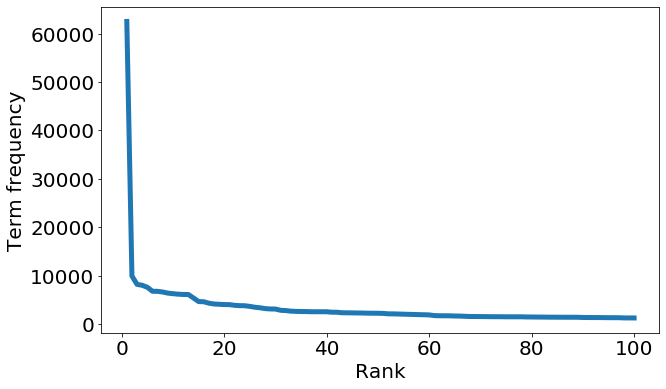

In [ ]:
word_and_frequency_pairs = term_frequency_counter.most_common(100)

plt.figure(figsize=SMALL_FIGSIZE)

y = [p[1] for p in word_and_frequency_pairs]
x = list(range(1, 1 + len(y)))

plt.plot(x, y, lw=LINEWIDTH)

plt.xlabel('Rank')
plt.ylabel('Term frequency')

plt.show()

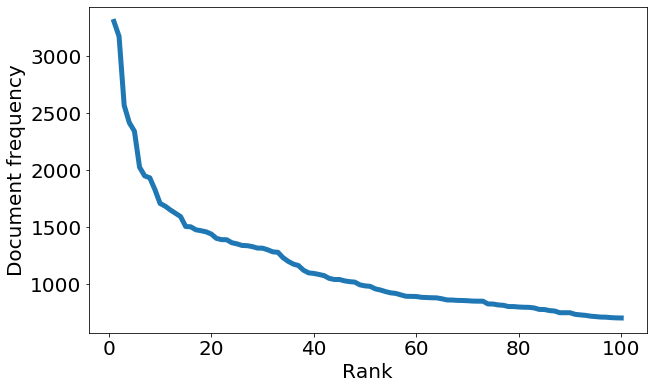

In [ ]:
word_and_frequency_pairs = document_frequency_counter.most_common(100)

plt.figure(figsize=SMALL_FIGSIZE)

y = [p[1] for p in word_and_frequency_pairs]
x = list(range(1, 1 + len(y)))

plt.plot(x, y, lw=LINEWIDTH)

plt.xlabel('Rank')
plt.ylabel('Document frequency')

plt.show()

In [ ]:
for counter, title in zip(
        [term_frequency_counter, document_frequency_counter],
        ['Term frequency', 'Document frequency']):

    print(title)
    print()

    for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
        result = np.percentile([pair[1] for pair in counter.most_common()], p)

        print(f'{p:2d}th percentile: {result:6.2f}')
    
    print()

Term frequency

 1th percentile:   1.00
 5th percentile:   1.00
10th percentile:   1.00
25th percentile:   1.00
50th percentile:   2.00
75th percentile:   5.00
90th percentile:  21.00
95th percentile:  55.00
99th percentile: 317.00

Document frequency

 1th percentile:   1.00
 5th percentile:   1.00
10th percentile:   1.00
25th percentile:   1.00
50th percentile:   1.00
75th percentile:   3.00
90th percentile:  14.00
95th percentile:  35.00
99th percentile: 188.00



Filtering too frequent and too rare words

In [ ]:
vocabulary_filtered_by_term_frequency = set(
    p[0] for p in term_frequency_counter.most_common()
    if p[1] >= 2.0 and p[1] < 100
)

print(len(vocabulary_filtered_by_term_frequency))

33272


In [ ]:
vocabulary_filtered_by_document_frequency = set(
    p[0] for p in document_frequency_counter.most_common()
    if p[1] >= 2.0 and p[1] < 35.0
)

print(len(vocabulary_filtered_by_document_frequency))

27560


What words were filtered by term frequency but not by document one

In [ ]:
print(vocabulary_filtered_by_document_frequency.difference(
    vocabulary_filtered_by_term_frequency
))

{'ei', 'filename', 'oname', 'di', 'stl', 'tq', 'aw', 'chz', 'det', 'cx', 'echo', 'ri', 'bj', 'lk', 'sk', 'wiring', 'r_', 'lib', 'biz', 'chi', 'hm', 'mv', 'rlk', 'azerbaijani', 'fp', 'nb', 'yf', 'mn', 'tg', 'kh', 'ff', 'outlet', 'qq', 'cipher', 'rl', 'ey', 'lj', 'gc', 'vw', 'eq', 'ww', 'fyn', 'azeri', 'buf', 'ez', 'char', 'bn', 'wm', 'sj', 'qax', 'iq', 'bm', 'kn', 'pu', 'lg', 'rk', 'mk', 'mov', 'b_', 'homicide', 'giz', 'stephanopoulos', 'que', 'm_', 'jz', 'mf', 'ql', 'greece', 'bhj', 'ripem', 'contest', 'mw', 'tor', 'te', 'nrhj', 'tb', 'pope', 'fij', 'anonymity', 'sq', 'uww', 'uy', 'hj', 'mj', 'myers', 'rg', 'gk', 'printf', 'bxn', 'irq', 'apartment', 'ml', 'eff', 'hiv', 'bh', 'mq', 'gq', 'sumgait', 'ho', 'pit', 'vz', 'cj', 'qy', 'mh', 'im', 'wt', 'ut', 'uw', 'fq', 'ck', 'jpeg', 'okz', 'militia', 'tu', 'yd', 'ra', 'c_', 'zd', 'tl', 'ottoman'}


As the final vocabulary we take the intersection of the above two

In [ ]:
filtered_vocabulary = vocabulary_filtered_by_document_frequency.intersection(
    vocabulary_filtered_by_term_frequency
)

print(len(filtered_vocabulary))

27440


In [ ]:
list(filtered_vocabulary)[-20:]

['recoverable',
 'pilon',
 'symbolized',
 'nunn',
 'junkyard',
 'sorensen',
 'mip',
 'w_',
 'qume',
 'yer',
 'gland',
 'keith_tkachuk',
 'irbe',
 'portability',
 'stool',
 'teroru',
 'overwhelmed',
 'smug',
 'miscellany',
 'incriminate']

Also we will delete too short words, consisting only of one or two letters

In [ ]:
filtered_vocabulary = set([
    w for w in filtered_vocabulary if len(w) >= 3
])

print(len(filtered_vocabulary))

26955


Len's count the number of words in each document, but only those words that are in the filtered vocabulary

In [ ]:
def count_words(texts, vocabulary):
    text_num_words = list()

    for text in texts:
        counter = Counter(text.split())
        num_words = 0

        for word in counter.keys():
            if word in vocabulary:
                num_words = num_words + 1

        text_num_words.append(num_words)
    
    return text_num_words

In [ ]:
train_document_num_words = count_words(preprocessed_train_texts, filtered_vocabulary)

In [ ]:
len(train_document_num_words)  # i.e. total number of documents

11314

In [ ]:
print('Number of filtered words in document')
print()

for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    result = np.percentile(train_document_num_words, p)
    
    print(f'{p:2d}th percentile: {result:6.2f}')

Number of filtered words in document

 1th percentile:   0.00
 5th percentile:   0.00
10th percentile:   1.00
25th percentile:   3.00
50th percentile:   7.00
75th percentile:  14.00
90th percentile:  27.00
95th percentile:  44.00
99th percentile: 152.61


Let's take some threshold and filter too big and small documents

In [ ]:
threshold = 100

print('Documents before filtering:', len(train_document_num_words))

targets, target_sizes = np.unique(
    [t for i, t in enumerate(train_dataset.target) if train_document_num_words[i] < threshold],
    return_counts=True
)

print('Documents  after filtering:', sum(target_sizes))

Documents before filtering: 11314
Documents  after filtering: 11112


Let's won't try to adjust the upper threshold any further: let it be equal 100 words.

In [ ]:
upper_threshold = 100

In [ ]:
threshold = 4

print('Documents before filtering:', len(train_document_num_words))

targets, target_sizes = np.unique(
    [t for i, t in enumerate(train_dataset.target) if train_document_num_words[i] >= threshold],
    return_counts=True
)

print('Documents  after filtering:', sum(target_sizes))

Documents before filtering: 11314
Documents  after filtering: 8049


Several thousand documents were thrown away. Are the topics still balanced?

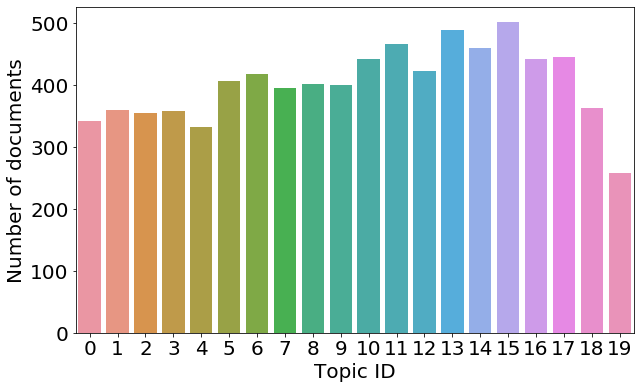

In [ ]:
plt.figure(figsize=SMALL_FIGSIZE)

sns.barplot(targets, target_sizes, alpha=1.0)

plt.xlabel('Topic ID')
plt.ylabel('Number of documents')

plt.show()

In [ ]:
print(
    'Number of documents after filtering:\n',
    sum(target_sizes)
)
print(
    'Absolute difference between most and least populated topics (in documents):\n',
    max(target_sizes) - min(target_sizes)
)
print(
    'Relative difference between most and least populated topics (in documents):\n',
    f'{(max(target_sizes) - min(target_sizes)) / min(target_sizes):.3f}'
)

Number of documents after filtering:
 8049
Absolute difference between most and least populated topics (in documents):
 243
Relative difference between most and least populated topics (in documents):
 0.942


So, there actually is some imbalance, but most topics still have roughly equal number of documents

Maybe there is a better threshold? Below we will go over several values, remembering the maximum difference between numbers of documents in topics (the lower this value, the better)

In [ ]:
quotients = list()
thresholds = list(range(20))

for threshold in thresholds:
    targets, target_sizes = np.unique(
        [t for i, t in enumerate(train_dataset.target) if train_document_num_words[i] >= threshold],
        return_counts=True
    )
    
    quotients.append(
        (max(target_sizes) - min(target_sizes)) / min(target_sizes)
    )

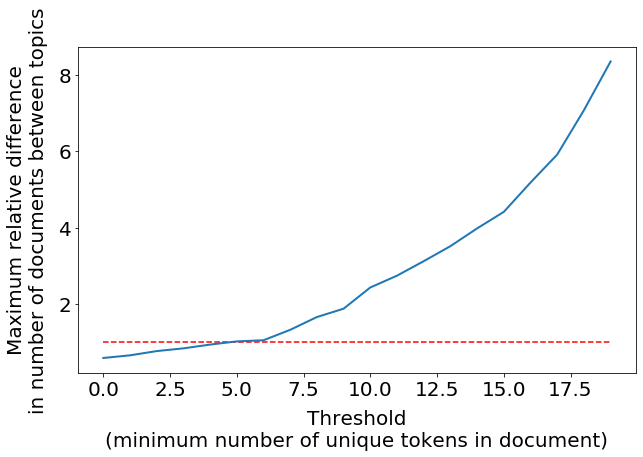

In [ ]:
plt.figure(figsize=SMALL_FIGSIZE)

plt.plot(thresholds, quotients, lw=2)
plt.hlines(1, 0, 19, linestyle='--', color='r')

plt.xlabel('Threshold\n(minimum number of unique tokens in document)', labelpad=LABELPAD)
plt.ylabel('Maximum relative difference\nin number of documents between topics', labelpad=LABELPAD)

plt.show()

Seems that the biggest acceptable threshold (the one which gives the relative difference less than one) is 4 unique words in document

In [ ]:
lower_threshold = 4

In [ ]:
good_train_document_indices = [
    i for i, n in enumerate(train_document_num_words)
    if n >= lower_threshold and n < upper_threshold
]

good_train_document_texts = list()

for i, text in enumerate(preprocessed_train_texts):
    if i not in good_train_document_indices:
        continue
    
    text = ' '.join([w for w in text.split() if w in filtered_vocabulary])
    
    good_train_document_texts.append(text)

In [ ]:
len(good_train_document_indices)

7847

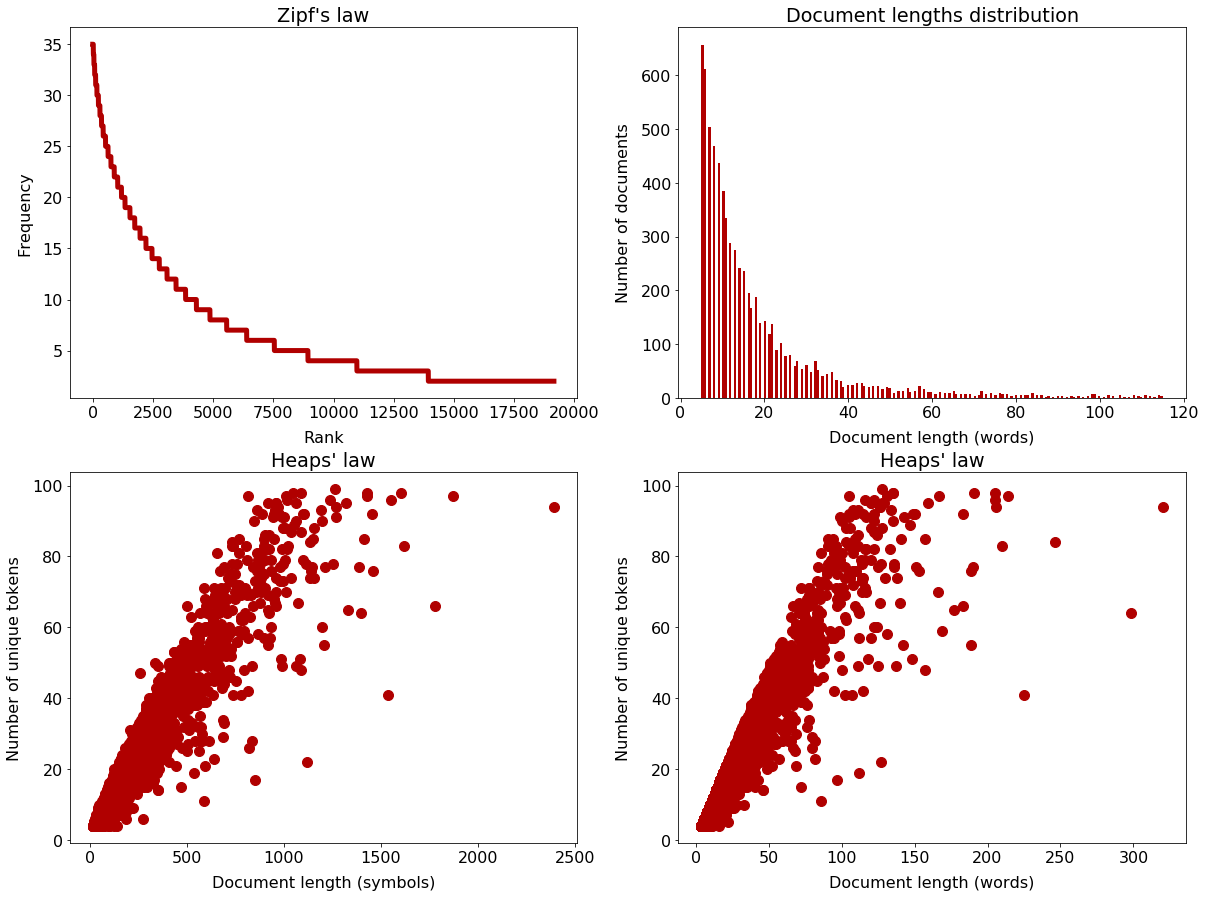

In [ ]:
draw_statistics(good_train_document_texts)

Also filtering test dataset

In [ ]:
test_document_num_words = count_words(preprocessed_test_texts, filtered_vocabulary)

In [ ]:
good_test_document_indices = [
    i for i, n in enumerate(test_document_num_words) if n >= lower_threshold and n < upper_threshold
]

good_test_document_texts = list()

for i, text in enumerate(preprocessed_test_texts):
    if i not in good_test_document_indices:
        continue
    
    text = ' '.join([w for w in text.split() if w in filtered_vocabulary])
    
    good_test_document_texts.append(text)

In [ ]:
len(good_test_document_indices)

4931

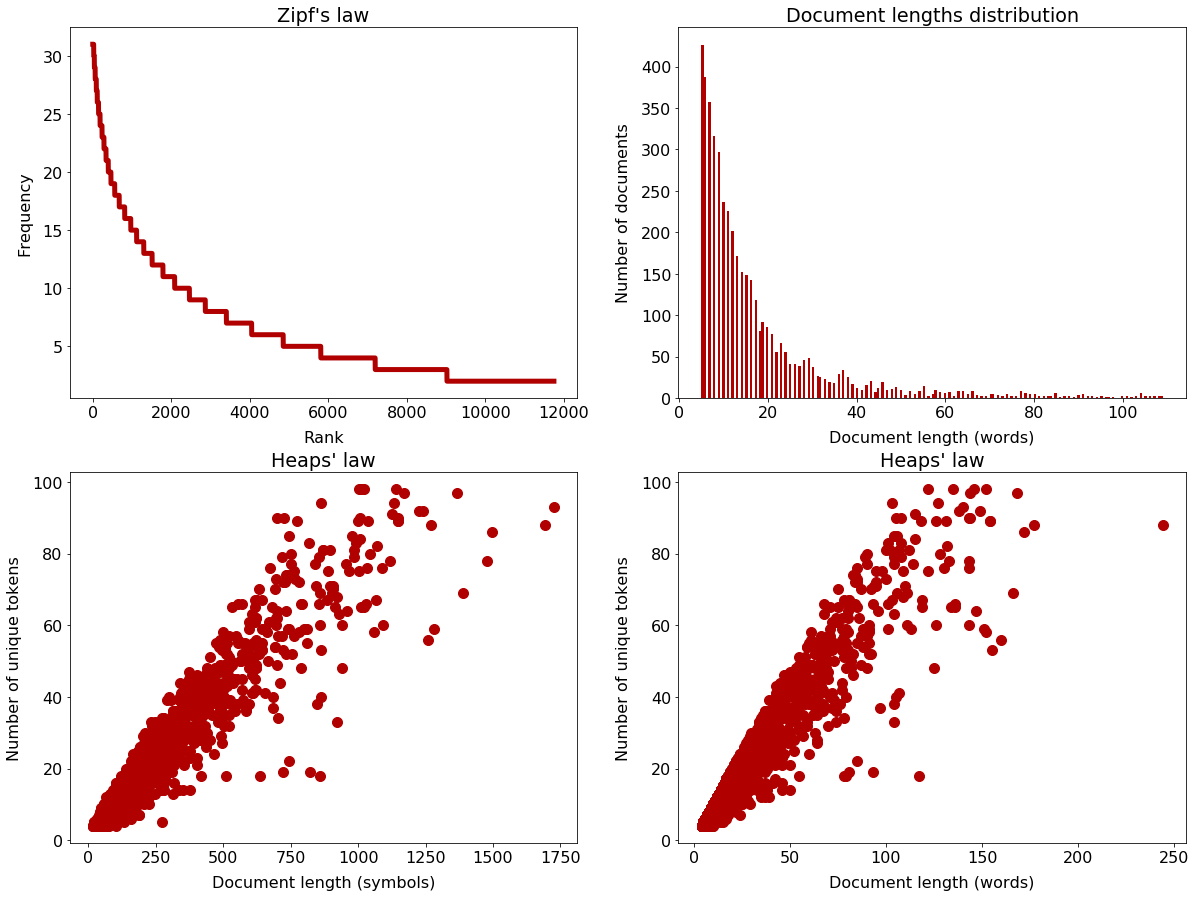

In [ ]:
draw_statistics(good_test_document_texts)

Train and test dataset parts even after preprocessing satisfy Zipf's and Heaps' laws, and the distribution of documents by lengths is the nearly the same for train and test parts.

# TopicNet<a id="topicnet"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Here starts the part connected with topic modeling with the help of BigARTM and TopicNet libraries.

All files, to be further generated in the notebook, are going to be saved in this directory

In [ ]:
working_directory = tempfile.mkdtemp()

In [ ]:
working_directory

'/tmp/tmpviynwz70'

In [ ]:
def prefix_path(path):
    return os.path.join(working_directory, path)

## Data Preparation<a id="topicnet-data-preparation"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

First, again, we need to do some things with data: prepare it for future models.

### Vowpal Wabbit<a id="vowpal-wabbit"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

* https://bigartm.readthedocs.io/en/v0.8.1/formats.html
* https://bigartm.readthedocs.io/en/stable/tutorials/datasets.html

We will use only one modality in this notebook. However, it is possible to train topic models for multimodal texts.

* https://bigartm.readthedocs.io/en/stable/tutorials/python_userguide/m_artm.html

In [ ]:
MODALITY = '@text'

In [ ]:
def to_vowpal_wabbit(document_names, document_texts, vocabulary, natural_order=True):
    vw_texts = list()

    for document_index, (document_name, text) in enumerate(zip(document_names, document_texts)):
        vw_line = f'{document_name}'
        vw_line = vw_line + f' |{MODALITY}'

        if natural_order:
            vw_line = vw_line + f' {text}'
        else:
            counter = Counter(text.split())

            for word, frequency in counter.items():
                if word not in vocabulary:
                    continue

                vw_line = vw_line + f' {word}:{frequency}'

        vw_texts.append(vw_line)
    
    return vw_texts

In [ ]:
train_document_names = [
    os.path.split(document_path)[-1] for i, document_path in enumerate(train_dataset.filenames)
    if i in good_train_document_indices
]

test_document_names = [
    os.path.split(document_path)[-1] for i, document_path in enumerate(test_dataset.filenames)
    if i in good_test_document_indices
]

We will save data in both formats: natural order and Bag of words order.
Natural one will help when computing word cooccurrence statistics.

In [ ]:
TRAIN = 'train'
TEST = 'test'

NATURAL_ORDER_SUFFIX = '_natural_order'
BAG_OF_WORDS_SUFFIX = ''

In [ ]:
train_test_vw_texts = dict()

for natural_order, word_order_suffix in zip(
        [True, False],
        [NATURAL_ORDER_SUFFIX, BAG_OF_WORDS_SUFFIX]):

    for document_names, document_texts, dataset_part_name in zip(
            [train_document_names, test_document_names],
            [good_train_document_texts, good_test_document_texts],
            [TRAIN, TEST]):

        vw_texts = to_vowpal_wabbit(
            document_names,
            document_texts,
            filtered_vocabulary,
            natural_order=natural_order
        )

        train_test_vw_texts[f'{dataset_part_name}{word_order_suffix}'] = vw_texts

        vw_text = '\n'.join(vw_texts)
        vw_file_name = f'{dataset_part_name}_vw{word_order_suffix}.txt'

        with open(prefix_path(vw_file_name), 'w') as f:
            f.write(vw_text)

Saved vw texts (we will need them in a couple of seconds)

In [ ]:
train_test_vw_texts.keys()

dict_keys(['train_natural_order', 'test_natural_order', 'train', 'test'])

In [ ]:
os.listdir(working_directory)

['test_dataset.csv',
 'train_dataset_natural_order.csv',
 'test_vw_natural_order.txt',
 'train_dataset.csv',
 'test_dataset_natural_order.csv',
 'train_vw_natural_order.txt',
 'test_vw.txt',
 'train_vw.txt']

TopicNet models also need special Dataset entity, which is currently a .csv table with certain columns, containing document texts

In [ ]:
for word_order_suffix in [NATURAL_ORDER_SUFFIX, BAG_OF_WORDS_SUFFIX]:

    for document_indices, raw_texts, dataset_part_name in zip(
            [good_train_document_indices, good_test_document_indices],
            [good_train_document_texts, good_test_document_texts],
            [TRAIN, TEST]):

        dataset_table = pd.DataFrame(
            index=document_indices,
            columns=['id', 'raw_text', 'vw_text']
        )

        vw_texts = train_test_vw_texts[f'{dataset_part_name}{word_order_suffix}']

        dataset_table['id'] = [text.split()[0] for text in vw_texts]
        dataset_table['raw_text'] = raw_texts
        dataset_table['vw_text'] = vw_texts

        dataset_table_file_name = f'{dataset_part_name}_dataset{word_order_suffix}.csv'

        dataset_table.to_csv(prefix_path(dataset_table_file_name), index=False)

In [ ]:
os.listdir(working_directory)

['test_dataset.csv',
 'train_dataset_natural_order.csv',
 'test_vw_natural_order.txt',
 'train_dataset.csv',
 'test_dataset_natural_order.csv',
 'train_vw_natural_order.txt',
 'test_vw.txt',
 'train_vw.txt']

Let's look at some table's first rows (this partucular table is not going to be used further, it just still exists as cycle inner variable in Python)

In [ ]:
dataset_table.head()

,id,raw_text,vw_text
1,67445,dpg uncompressed anyones swamped,67445 |@text dpg:1 uncompressed:1 anyones:1 sw...
3,77355,iraqi kuwait saudi iraqi swallowed saudi arabi...,77355 |@text iraqi:3 kuwait:2 saudi:6 swallowe...
5,59518,nth yeast brainwashing hated microbiology cand...,59518 |@text nth:1 yeast:4 brainwashing:1 hate...
7,21684,lexicon wordperfect wiped restore distributor ...,21684 |@text lexicon:1 wordperfect:1 wiped:1 r...
8,67466,dynamically closing cleanup transition anticipate,67466 |@text dynamically:1 closing:1 cleanup:1...


Let's now create TopicNet's Datasets using saved .csv tables

In [ ]:
dataset = Dataset(prefix_path(f'{TRAIN}_dataset.csv'))
holdout_dataset = Dataset(prefix_path(f'{TEST}_dataset.csv'))

In [ ]:
dataset._data.head()

,raw_text,vw_text
id,,
102994,enlighten bricklin bumper funky,102994 |@text enlighten:1 bricklin:1 bumper:1 ...
51861,upgraded oscillator poll detailing attained si...,51861 |@text upgraded:1 oscillator:1 poll:2 de...
51879,ghost sooo sooner picking powerbook dirt power...,51879 |@text ghost:1 sooo:1 sooner:1 picking:1...
60880,std std baker suchlike introduce liftoff,60880 |@text std:2 baker:1 suchlike:1 introduc...
54525,rigidly allegedly presenting evidently,54525 |@text rigidly:1 allegedly:1 presenting:...


In [ ]:
holdout_dataset._data.head()

,raw_text,vw_text
id,,
67445,dpg uncompressed anyones swamped,67445 |@text dpg:1 uncompressed:1 anyones:1 sw...
77355,iraqi kuwait saudi iraqi swallowed saudi arabi...,77355 |@text iraqi:3 kuwait:2 saudi:6 swallowe...
59518,nth yeast brainwashing hated microbiology cand...,59518 |@text nth:1 yeast:4 brainwashing:1 hate...
21684,lexicon wordperfect wiped restore distributor ...,21684 |@text lexicon:1 wordperfect:1 wiped:1 r...
67466,dynamically closing cleanup transition anticipate,67466 |@text dynamically:1 closing:1 cleanup:1...


### Cooccurrences<a id="cooccurrences"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

ATTENTION! This section is semi-manual: one will need to do some things outside of the notebook, namely run instructions in command line.
If you don't want/can't/don't have enough time to do this kind of stuff, leave the `WITH_COOCS` variable equal `False`, and everything will be fine (you still may run *all* the remaining cells in the notebook).
However, it is highly recommended to try calculate cooccurrence statistics as described below.
This will give an opprotunity to evaluate the quality of topic models more thoroughly and thoughtfully.
To delve into coocs, set `WITH_COOCS` equal `True`.

In [ ]:
WITH_COOCS = False

Topic models basically deal with text in bag-of-words format (when word order doesn't matter).
Natural order vowpal wabbit files were needed for gathering word cooccurrence statistics.
And this, in turn, will be needed further for evaluation of the quality of topics of topic models using coherence (one of many BigARTM *scores*).

First, we need vocab in UCI bag-of-words format

* https://bigartm.readthedocs.io/en/stable/tutorials/datasets.html

In [ ]:
vocab = ''

for word in filtered_vocabulary:
    vocab += f'{word} {MODALITY}\n'

with open(prefix_path('vocab.txt'), 'w') as f:
    f.write(vocab)

open(prefix_path('vocab.txt'), 'r').readlines()[:2]

['lund @text\n', 'pina @text\n']

Now we are approaching the stage of gathering cooccurrence statistics...
It can be done with the help of BigARTM library (or more precisely BigARTM Command line utility).
There are several links one can visit to get some knowledge about the process.

* Coherence: https://bigartm.readthedocs.io/en/stable/tutorials/python_userguide/coherence.html
* Command line utility: https://bigartm.readthedocs.io/en/stable/tutorials/bigartm_cli.html
* Example of gathering coocs statistics (in Russian): https://nbviewer.jupyter.org/github/bigartm/bigartm-book/blob/master/junk/cooc_dictionary/example_of_gathering.ipynb

So, unfortunately, it is impossible currently (with artm version '0.10.0' at least) to do everything just here in the notebook.
One should use the command line utility.
Here is an example of bash command line instruction which helps to run the utility (it might be more convenient to place it into a .sh script)

```bash
cd <working_directory path> && <path to the folder where bigartm resides>/bigartm/build/bin/bigartm \
    -c train_vw_natural_order.txt \
    -v vocab.txt \
    --cooc-window 10 \
    --cooc-min-tf 1 \
    --write-cooc-tf cooc_tf_ \
    --cooc-min-df 1 \
    --write-cooc-df cooc_df_ \
    --write-ppmi-tf ppmi_tf_ \
    --write-ppmi-df ppmi_df_
```

If everything worked fine, now we have coocs data calculated

In [ ]:
os.listdir(working_directory)

['test_dataset.csv',
 'coocs.sh',
 'cooc_tf_',
 'train_dataset_natural_order.csv',
 'vocab.txt',
 'test_vw_natural_order.txt',
 'ppmi_df_',
 'train_dataset.csv',
 'test_dataset_natural_order.csv',
 'train_vw_natural_order.txt',
 'ppmi_tf_',
 'cooc_df_',
 'bigartm.miptai.vasiliyalekseev.log.INFO.20200108-112018.3790',
 'test_vw.txt',
 'bigartm.INFO',
 'train_vw.txt']

Let's look at the first lines of one of the gerenared coocs files

In [ ]:
if WITH_COOCS is True:
    print(
        open(prefix_path('ppmi_tf_'), 'r').readlines()[:2]
    )

['@text pina asserts:7.92826 snap:7.93756 periodically:7.07306 oxidize:10.6645 clip:7.01754 independently:7.70512\n',
 '@text periphery accor:8.2872 inherent:5.65684 evolved:6.9239 atheistic:6.64791 measuring:6.56878 theistic:7.47965 disputed:6.04714 valued:6.46559 leap:5.08668 selfish:5.5493 selfishness:7.40169 assign:6.96343 unnecessary:5.1193 idle:4.54522 stance:5.94598 exposition:8.09483 intrinsically:6.28245 theist:4.86403 resemblance:6.93168 qualitatively:7.79473\n']

It would seem that this should already be enough, but according to the mentioned link https://bigartm.readthedocs.io/en/stable/tutorials/python_userguide/coherence.html the author of this notebook didn't manage to run the needed BigARTM score...
Therefore, we need another little preprocessing.

In [ ]:
def transform_coocs_file(source_file_path, target_file_path, vocab_file_path):
    """
    source_file is assumed to be either ppmi_tf_ or ppmi_df_ 
    """
    num_times_to_log = 10

    vocab = open(vocab_file_path, 'r').readlines()
    vocab = [l.strip().split()[0] for l in vocab]
    
    cooc_values = dict()
    word_word_value_triples = set()
    
    lines = open(source_file_path, 'r').readlines()
    
    for i, l in enumerate(lines):
        if i % (len(lines) // num_times_to_log) == 0:
            print(f'{i:6d} lines out of {len(lines)}')
        
        l = l.strip()
        words = l.split()
        words = words[1:]  # exclude modality
        anchor_word = words[0]
        
        other_word_values = words[1:]
        
        for word_and_value in other_word_values:
            other_word, value = word_and_value.split(':')
            value = float(value)
            
            cooc_values[(anchor_word, other_word)] = value
            cooc_values[(other_word, anchor_word)] = value  # if assume cooc values to be symmetric
            
            word_word_value_triples.add(
                tuple([
                    tuple(sorted([
                        vocab.index(anchor_word),
                        vocab.index(other_word)
                    ])),
                    value
                ])
            )
    
    new_text = ''
    
    for (w1, w2), v in word_word_value_triples:
        new_text += f'{w1} {w2} {v}\n'
    
    with open(target_file_path, 'w') as f:
        f.write(''.join(new_text))
    
    return cooc_values

`cooc_values` is a dictionary which maps a word pair to its cooc value

In [ ]:
if WITH_COOCS is True:
    cooc_values = transform_coocs_file(
        prefix_path('ppmi_tf_'),
        prefix_path('new_ppmi_tf_'),
        prefix_path('vocab.txt')
    )

     0 lines out of 21910
  2191 lines out of 21910
  4382 lines out of 21910
  6573 lines out of 21910
  8764 lines out of 21910
 10955 lines out of 21910
 13146 lines out of 21910
 15337 lines out of 21910
 17528 lines out of 21910
 19719 lines out of 21910


In [ ]:
if WITH_COOCS is True:
    print(list(cooc_values.items())[:10])

[(('pina', 'asserts'), 7.92826),
 (('asserts', 'pina'), 7.92826),
 (('pina', 'snap'), 7.93756),
 (('snap', 'pina'), 7.93756),
 (('pina', 'periodically'), 7.07306),
 (('periodically', 'pina'), 7.07306),
 (('pina', 'oxidize'), 10.6645),
 (('oxidize', 'pina'), 10.6645),
 (('pina', 'clip'), 7.01754),
 (('clip', 'pina'), 7.01754)]

Let's save also this coocs values dictionary

In [ ]:
if WITH_COOCS is True:
    with open(prefix_path('cooc_values.json'), 'w') as f:
        f.write(json.dumps(list(cooc_values.items())))

Checking if all OK after saving

In [ ]:
if WITH_COOCS is True:
    saved_raw_cooc_values = json.loads(open(prefix_path('cooc_values.json'), 'r').read())

    saved_cooc_values = {
        tuple(d[0]): d[1] for d in saved_raw_cooc_values
    }

In [ ]:
if WITH_COOCS is True:
    print(list(saved_cooc_values.items())[:10])

[(('pina', 'asserts'), 7.92826),
 (('asserts', 'pina'), 7.92826),
 (('pina', 'snap'), 7.93756),
 (('snap', 'pina'), 7.93756),
 (('pina', 'periodically'), 7.07306),
 (('periodically', 'pina'), 7.07306),
 (('pina', 'oxidize'), 10.6645),
 (('oxidize', 'pina'), 10.6645),
 (('pina', 'clip'), 7.01754),
 (('clip', 'pina'), 7.01754)]

## Model Initialization<a id="model-initialization"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Finally we come to building topic models!

Below are functions which attach some regularizers to ARTM model

* https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html
* https://bigartm.readthedocs.io/en/stable/tutorials/python_userguide/regularizers_and_scores.html
* https://bigartm.readthedocs.io/en/v0.8.1/python_interface/regularizers.html

In [ ]:
SPARSE_PHI_SPECIFIC = 'sparse_phi_specific'
SPARSE_THETA_SPECIFIC = 'sparse_theta_specific'
SMOOTH_PHI_BACKGROUND = 'smooth_phi_background'
SMOOTH_THETA_BACKGROUND = 'smooth_theta_background'

DECORRELATE_SPECIFIC = 'decorrelate_specific'
DECORRELATE_BACKGROUND = 'decorrelate_background'

SELECT_TOPICS = 'select_topics'


def initialize_smoothing_sparsing_regularizers(
        specific_topic_names,
        background_topic_names,
        specific_class_ids,
        background_class_ids):

    return [
        artm.SmoothSparsePhiRegularizer(
            tau=0,
            name=SPARSE_PHI_SPECIFIC,
            topic_names=specific_topic_names,
            class_ids=specific_class_ids
        ),
        artm.SmoothSparseThetaRegularizer(
            tau=0,
            name=SPARSE_THETA_SPECIFIC,
            topic_names=specific_topic_names
        ),
        artm.SmoothSparsePhiRegularizer(
            tau=0,
            name=SMOOTH_PHI_BACKGROUND,
            topic_names=background_topic_names,
            class_ids=background_class_ids
        ),
        artm.SmoothSparseThetaRegularizer(
            tau=0,
            name=SMOOTH_THETA_BACKGROUND,
            topic_names=background_topic_names
        ),
    ]


def initialize_decorrelating_regularizers(
        specific_topic_names,
        background_topic_names,
        specific_class_ids,
        background_class_ids):

    return [
        artm.DecorrelatorPhiRegularizer(
            tau=0,
            name=DECORRELATE_SPECIFIC,
            topic_names=specific_topic_names,
            class_ids=specific_class_ids,
        ),
        artm.DecorrelatorPhiRegularizer(
            tau=0,
            name=DECORRELATE_BACKGROUND,
            topic_names=background_topic_names,
            class_ids=background_class_ids,
        )
    ]


def initialize_topic_selecting_regularizers(specific_topic_names):
    return [
        artm.TopicSelectionThetaRegularizer(
            tau=0,
            name=SELECT_TOPICS,
            topic_names=specific_topic_names
        )
    ]

There are many scores, already implemented in BigARTM.
However, sometimes you may need more than that.
So let's now define a couple of TopicNet custom scores.

In [ ]:
class TopicKernelSizeScore(BaseScore):
    """
    Calculates size of topic kernel, i.e. number of words
    where probability p(w | t) is bigger than the uniform one 1.0 / |V|
    
    """
    def __init__(self, specific_topic_names, average='median'):
        super().__init__()
        
        self._specific_topic_names = specific_topic_names
        self._average = average
        
        if self._average not in ['median', 'mean']:
            raise ValueError(self._average)

    def call(self, model):
        if len(self._specific_topic_names) == 0:
            return 0

        kernel_sizes = list()
        subphi_values = model.get_phi().loc[:, self._specific_topic_names].values
        vocabulary_size = subphi_values.shape[0]
        
        for i, topic_name in enumerate(self._specific_topic_names):
            phi_column = subphi_values[:, i]
            kernel_size = len(phi_column[phi_column > 1.0 / vocabulary_size])
            
            kernel_sizes.append(kernel_size)
        
        if len(kernel_sizes) == 0:
            return 0.0
        
        if self._average == 'median':
            return np.median(kernel_sizes)

        elif self._average == 'mean':
            return np.mean(kernel_sizes)

        else:
            raise ValueError(self._average)

In [ ]:
class ActiveTopicNumberScore(BaseScore):
    """
    Calculates number of active topics, i.e. those ones which have at least one document
    
    """
    def __init__(self, specific_topic_names, dataset, threshold=0):
        """
        threshold — minimum probability p(t | d) to consider the document "d" to be related to the topic "t"
        
        """
        super().__init__()
        
        self._threshold = threshold
        self._specific_topic_names = specific_topic_names
        self._dataset = dataset  # TODO: cache theta didn't work for some reason, so can't do without dataset...
  
    def call(self, model):
        if len(self._specific_topic_names) == 0:
            return 0

        theta = model._model.transform(dataset.get_batch_vectorizer())
        subtheta_values = theta.loc[self._specific_topic_names, :].values
        max_probs = np.max(subtheta_values, axis=1)
        
        return len(max_probs[max_probs > self._threshold])

ARTM has PerplexityScore, which is computed using training dataset.
Here we define HoldoutPerplexityScore, which is to be computed on test part of the dataset.

* https://github.com/bigartm/bigartm/wiki/Q&A#how-to-calculate-perplexity-on-held-out-sample

In [ ]:
class HoldoutPerplexityScore(BaseScore):
    def __init__(self, perplexity_score, test_dataset):
        super().__init__()
        
        self._perplexity_score = perplexity_score
        self._dataset = test_dataset

    def call(self, model):
        model._model.transform(
            batch_vectorizer=self._dataset.get_batch_vectorizer(),
            theta_matrix_type=None
        )

        perplexity = model._model.get_score(self._perplexity_score)

        return perplexity.value

And here is the score for which we previously calculated all the coocs stuff.
ARTM has a coherence score implemented, but the author didn't succeed in making it work.

In [ ]:
class TopTokensCoherenceScore(BaseScore):
    def __init__(
            self,
            cooc_values,
            modality,
            topics, 
            num_top_tokens=10,
            kernel=False,
            average='mean',
            active_topic_threshold=None,
            dataset=None):
        """
        kernel — use only tokens from topic kernel
        active_topic_threshold — if defined, non active topics won't be considered
        
        """
        super().__init__()
        
        self._cooc_values = cooc_values
        self._modality = modality
        self._topics = topics
        self._num_top_tokens = num_top_tokens
        self._kernel = kernel
        self._average = average
        self._active_topic_threshold = active_topic_threshold
        self._dataset = dataset
        
        if self._average not in ['median', 'mean']:
            raise ValueError(self._average)

    def call(self, model):
        subphi = model.get_phi().loc[self._modality, self._topics]
        vocabulary_size = subphi.shape[0]
        
        topic_coherences = list()
        
        if self._active_topic_threshold is None:
            topics = self._topics
        else:
            # TODO: can't do without transform here, cache theta didn't help
            theta = model._model.transform(dataset.get_batch_vectorizer())
            subtheta_values = theta.loc[self._topics, :].values
            max_probs = np.max(subtheta_values, axis=1)
            active_topic_indices = np.where(max_probs > self._active_topic_threshold)[0]
            topics = [t for i, t in enumerate(self._topics) if i in active_topic_indices]

        for topic in topics:
            topic_column = subphi.loc[:, topic]

            if not self._kernel:
                tokens = topic_column.sort_values(ascending=False)[:self._num_top_tokens].index.to_list()
            else:
                # if self._num_top_tokens is None — also Ok
                tokens = topic_column[topic_column > 1.0 / vocabulary_size][:self._num_top_tokens].index.to_list()

            current_cooc_values = list()
            
            for token_a, token_b in combinations(tokens, 2):
                if (token_a, token_b) in self._cooc_values:
                    current_cooc_values.append(self._cooc_values[(token_a, token_b)])
                elif (token_b, token_a) in self._cooc_values:
                    current_cooc_values.append(self._cooc_values[(token_b, token_a)])
                else:
                    # warnings.warn(f'Cooc pair "{token_a}, {token_b}" not found in provided data')
                    current_cooc_values.append(0)
                
            if len(current_cooc_values) > 0:
                topic_coherences.append(np.mean(current_cooc_values))
            else:
                topic_coherences.append(0)

        if len(topic_coherences) == 0:
            return 0

        elif self._average == 'mean':
            return np.mean(topic_coherences)
        elif self._average == 'median':
            return np.median(topic_coherences)
        else:
            raise ValueError(f'Don\'t know how to average like {self._average}')

The function below builds and ARTM topic model with all the mentioned scores.
All the scores have parameter tau set to zero, so they shouldn't affect the training process anyhow.
However, with some nonzero tau, a score will play its role.

In [ ]:
NUM_SPECIFIC_TOPICS = 100
NUM_BACKGROUND_TOPICS = 2
NUM_TOPICS = NUM_SPECIFIC_TOPICS + NUM_BACKGROUND_TOPICS

SPECIFIC_TOPIC_NAMES = [f'spec_topic_{i}' for i in range(NUM_SPECIFIC_TOPICS)]
BACKGROUND_TOPIC_NAMES = [f'back_topic_{i}' for i in range(NUM_BACKGROUND_TOPICS)]

TOP_TOKENS_SCORE = 'TopTokensScore'
TOPIC_KERNEL_SIZE_SCORE = 'TopicKernelSizeScore'
ACTIVE_TOPIC_NUMBER_SCORE = 'ActiveTopicNumberScore'
HOLDOUT_PERPLEXITY_SCORE = 'HoldoutPerplexityScore'
TOP_TOKENS_COHERENCE_SCORE = 'TopTokensCoherenceScore'
PERPLEXITY_SCORE = 'PerplexityScore'         # don't change this, as it is defined this way in TopicNet's function
SPARSITY_PHI_SCORE = 'SparsityPhiScore'      # ...and this
SPARSITY_THETA_SCORE = 'SparsityThetaScore'  # ...and this
TOPIC_KERNEL_SCORE = 'TopicKernel'           # ...and this


def initialize_topic_model():
    artm_model = artm.ARTM(
        num_processors=1,  # can be changed for faster computing, but here we won't use it
        topic_names=SPECIFIC_TOPIC_NAMES + BACKGROUND_TOPIC_NAMES,
        cache_theta=True,  # TODO: even with True fails to get theta inside scores
        class_ids={
            MODALITY: 1.0
        },
        num_document_passes=1,
        dictionary=dataset.get_dictionary()
    )

    smoothing_sparsing_regularizers = initialize_smoothing_sparsing_regularizers(
        SPECIFIC_TOPIC_NAMES, BACKGROUND_TOPIC_NAMES, [MODALITY], [MODALITY]
    )
    decorrelating_regularizers = initialize_decorrelating_regularizers(
        SPECIFIC_TOPIC_NAMES, BACKGROUND_TOPIC_NAMES, [MODALITY], [MODALITY]
    )
    topic_selecting_regularizers = initialize_topic_selecting_regularizers(
        SPECIFIC_TOPIC_NAMES
    )

    for regularizer in smoothing_sparsing_regularizers + decorrelating_regularizers + topic_selecting_regularizers:
        artm_model.regularizers.add(regularizer, overwrite=True)

    add_standard_scores(
        artm_model,
        dataset.get_dictionary(),
        main_modality=MODALITY,
        all_modalities=[MODALITY]
    )
    
    for num_tokens in [20]:
        artm_model.scores.add(
            artm.TopTokensScore(
                name=f'{TOP_TOKENS_SCORE}_{num_tokens}',
                class_id=MODALITY,
                topic_names=SPECIFIC_TOPIC_NAMES,
                num_tokens=num_tokens,
                # dictionary=cooc_dictionary  # TODO: failed to make this work
            )
        )

    custom_scores = {
        TOPIC_KERNEL_SIZE_SCORE: TopicKernelSizeScore(SPECIFIC_TOPIC_NAMES)
    }
    
    for threshold in [0, 1e-7, 1e-3, 0.01, 0.1]:
        custom_scores[f'{ACTIVE_TOPIC_NUMBER_SCORE}_{threshold}'] = \
            ActiveTopicNumberScore(
                SPECIFIC_TOPIC_NAMES,
                dataset,
                threshold
            )
    
    custom_scores[f'{HOLDOUT_PERPLEXITY_SCORE}{MODALITY}'] = HoldoutPerplexityScore(
        f'{PERPLEXITY_SCORE}{MODALITY}', holdout_dataset
    )
    
    if WITH_COOCS is True:
        for num_top_tokens in [10, 50, 100]:  # 100 - for faster computing — ideally would be None
            custom_scores[f'{TOP_TOKENS_COHERENCE_SCORE}_kernel_{num_top_tokens}'] = TopTokensCoherenceScore(
                cooc_values,
                MODALITY,
                SPECIFIC_TOPIC_NAMES,
                num_top_tokens=num_top_tokens,
                kernel=True,                  # using only words from topic kernel
                average='median',
                active_topic_threshold=1e-7,  # taking some threshold a little bit above zero  just in case
                dataset=dataset
            )

    topic_model = TopicModel(
        artm_model,
        model_id='Root Model',
        custom_scores=custom_scores
    )

    experiment = Experiment(
        experiment_id=datetime.now().strftime('%Y-%m-%d__%H-%M-%S'),
        save_path=prefix_path('Experiments'),
        topic_model=topic_model
    )
    
    return topic_model

Initializing some model to check if all works

In [ ]:
test_model = initialize_topic_model()

Checking model scores

In [ ]:
test_model.scores

{'PerplexityScore@all': [],
 'SparsityThetaScore': [],
 'SparsityPhiScore@text': [],
 'PerplexityScore@text': [],
 'TopicKernel@text': [],
 'TopTokensScore_20': [],
 'TopicKernelSizeScore': [],
 'ActiveTopicNumberScore_0': [],
 'ActiveTopicNumberScore_1e-07': [],
 'ActiveTopicNumberScore_0.001': [],
 'ActiveTopicNumberScore_0.01': [],
 'ActiveTopicNumberScore_0.1': [],
 'HoldoutPerplexityScore@text': [],
 'TopTokensCoherenceScore_kernel_10': [],
 'TopTokensCoherenceScore_kernel_50': [],
 'TopTokensCoherenceScore_kernel_100': []}

In [ ]:
del test_model

## Fixing Regularizer Parameters<a id="fixing-regularizers"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

We want to use several regularizers during training (particularly decorrelation and topic selection).
It would be very time consuming if we tried to combine these regularizers in different ways and vary regularizer parameters in parallel.
So let's find some parameters beforehand: using only one regularizer, we find its best parameter tau.
And in all further complex strategies (with several regularizers) regularizers' parameters will be fixed and equal to these found best taus.

Each regularizer will act during some number of iterations

In [ ]:
NUM_CUBE_ITERATIONS = 20

Criteria to select best model.
One cas use `COHERENCE_CRITERION`, but let's fix `PERPLEXITY_CRITERION` as the criterion for selecting best parameters: we don't want to find the best model here in terms of interpretability, we just want to fix some good regularizer parameters which help to train such models which describes the collection well (i.e. perplexity is as low as possible).

In [ ]:
PERPLEXITY_CRITERION = f'{PERPLEXITY_SCORE}{MODALITY} -> min COLLECT 1'
COHERENCE_CRITERION  = f'{TOP_TOKENS_COHERENCE_SCORE}_kernel_10 -> max COLLECT 1'

CRITERION = PERPLEXITY_CRITERION

During model training currently there may be many warnings (if custom score saving fails).
Below is kinda a workaround: this functions helps to hide all the warnings in the Jupyter notebook after running the cell where the function is invoked.

* https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython

In [ ]:
from IPython.display import display_html, HTML

def enable_hide_warnings():
    display_html(HTML('''<script>
code_show_err=false;

function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
}

$( document ).ready(code_toggle_err);
</script>

To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.'''))

The function below draws plots of given scores depending on training iteration

In [ ]:
SCORES = [
    f'{PERPLEXITY_SCORE}{MODALITY}',
    f'{HOLDOUT_PERPLEXITY_SCORE}{MODALITY}',
    f'{SPARSITY_PHI_SCORE}{MODALITY}',
    f'{SPARSITY_THETA_SCORE}',
    f'{TOPIC_KERNEL_SCORE}{MODALITY}.average_contrast',
    f'{TOPIC_KERNEL_SCORE}{MODALITY}.average_purity',
    f'{TOPIC_KERNEL_SIZE_SCORE}',
    f'{ACTIVE_TOPIC_NUMBER_SCORE}_0',
    f'{ACTIVE_TOPIC_NUMBER_SCORE}_1e-07',
    f'{ACTIVE_TOPIC_NUMBER_SCORE}_0.001'
]

if WITH_COOCS is True:
    SCORES.append(f'{TOP_TOKENS_COHERENCE_SCORE}_kernel_10')
    SCORES.append(f'{TOP_TOKENS_COHERENCE_SCORE}_kernel_50')
    SCORES.append(f'{TOP_TOKENS_COHERENCE_SCORE}_kernel_100')


def draw_plots(model, scores=SCORES, num_cols=2, font_size=10):
    old_font_size = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': font_size})
    
    num_rows = int(np.ceil(len(scores) / num_cols))

    one_plot_width = 4
    one_plot_heigth = 7
    
    fig, axes = plt.subplots(
        num_rows, num_cols,
        figsize=(num_cols * one_plot_heigth, num_rows * one_plot_width)
    )
    
    iterations = list(range(1, len(model.scores[scores[0]]) + 1))
    
    for i, score in enumerate(scores):
        ax = axes[i // num_cols][i % num_cols]
        
        ax.plot(iterations, model.scores[score], lw=5)
        
        ax.set_ylabel(score)
        ax.set_xlabel('Iteration')

    plt.subplots_adjust(
        hspace=0.25, wspace=0.25
    )
    plt.show()
    
    plt.rcParams.update({'font.size': old_font_size})

### Decorrelation<a id="fixing-decorrelation"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

* https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html#decorrelator-phi

In [ ]:
decorrelating_regularizer_parameters = {
    'regularizer': artm.DecorrelatorPhiRegularizer(
        tau=0,
        name=DECORRELATE_SPECIFIC,
        topic_names=SPECIFIC_TOPIC_NAMES,
        class_ids=[MODALITY],
    ),
    'tau_grid': [1, 10, 100, 1000, 1e4, 1e5, 1e6]
}

decorrelating_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=decorrelating_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

One can view the cube parameters (for example if there is a need to remember the grid)

In [ ]:
decorrelating_cube.parameters

[{'object': <artm.regularizers.DecorrelatorPhiRegularizer at 0x7fab58909d68>,
  'field': 'tau',
  'values': [1, 10, 100, 1000, 10000.0, 100000.0, 1000000.0]}]

In [ ]:
enable_hide_warnings()

topic_model = initialize_topic_model()

To toggle on/off output_stderr, click here .

Custom scores are those ones, defined in this notebook as new classes

In [ ]:
topic_model.custom_scores

{'TopicKernelSizeScore': <__main__.TopicKernelSizeScore at 0x7fabc3c9d898>,
 'ActiveTopicNumberScore_0': <__main__.ActiveTopicNumberScore at 0x7fab528b8860>,
 'ActiveTopicNumberScore_1e-07': <__main__.ActiveTopicNumberScore at 0x7fabc36c0780>,
 'ActiveTopicNumberScore_0.001': <__main__.ActiveTopicNumberScore at 0x7fabc39c2550>,
 'ActiveTopicNumberScore_0.01': <__main__.ActiveTopicNumberScore at 0x7fab602047f0>,
 'ActiveTopicNumberScore_0.1': <__main__.ActiveTopicNumberScore at 0x7fabc3616be0>,
 'HoldoutPerplexityScore@text': <__main__.HoldoutPerplexityScore at 0x7fab5892af28>,
 'TopTokensCoherenceScore_kernel_10': <__main__.TopTokensCoherenceScore at 0x7fabb7d58748>,
 'TopTokensCoherenceScore_kernel_50': <__main__.TopTokensCoherenceScore at 0x7fabc338be80>,
 'TopTokensCoherenceScore_kernel_100': <__main__.TopTokensCoherenceScore at 0x7fabc3491dd8>}

In [ ]:
%%time

enable_hide_warnings()

models = decorrelating_cube(topic_model, dataset)  # TODO: nice cube output?

To toggle on/off output_stderr, click here .

CPU times: user 24min 46s, sys: 1min 20s, total: 26min 6s
Wall time: 20min 56s


In experiment there are several models: root one, and one per each parameter tau specified in cube settings

In [ ]:
topic_model.experiment.models

{'<<<<<<<<<<<root>>>>>>>>>>>': <cooking_machine.models.topic_model.TopicModel at 0x7fabc3cadd30>,
 '##16h33m41s_08d01m2020y###': <cooking_machine.models.dummy_topic_model.DummyTopicModel at 0x7fab538c0d30>,
 '##16h36m07s_08d01m2020y###': <cooking_machine.models.dummy_topic_model.DummyTopicModel at 0x7fab25f9db00>,
 '##16h38m34s_08d01m2020y###': <cooking_machine.models.dummy_topic_model.DummyTopicModel at 0x7fab5281f668>,
 '##16h41m00s_08d01m2020y###': <cooking_machine.models.dummy_topic_model.DummyTopicModel at 0x7fab5280b6d8>,
 '##16h43m26s_08d01m2020y###': <cooking_machine.models.dummy_topic_model.DummyTopicModel at 0x7fab518fcc50>,
 '##16h45m53s_08d01m2020y###': <cooking_machine.models.dummy_topic_model.DummyTopicModel at 0x7fab51d71a58>,
 '##16h48m18s_08d01m2020y###': <cooking_machine.models.dummy_topic_model.DummyTopicModel at 0x7fab50f99d68>}

Function showing last score values (so as to make it easier to compare all models in the end and choose the best one)

In [ ]:
def show_scores(model, score_names):
    for score_name in score_names:
        print(f'{score_name:40} {model.scores[score_name][-1]:>10.3f}')

And the best model by criterion is...

In [ ]:
def select_best_model(experiment, criterion, regularizer_name):
    best_model = experiment.select(criterion)[0]
    
    print(criterion)
    print()

    show_scores(best_model, SCORES)
    print()
    
    best_tau = best_model.regularizers[regularizer_name].tau
    
    print('Tau: {}'.format(best_tau))
    
    return best_model, best_tau

In [ ]:
enable_hide_warnings()

best_model, DECORRELATION_TAU = select_best_model(
    topic_model.experiment, CRITERION, DECORRELATE_SPECIFIC
)

To toggle on/off output_stderr, click here .

PerplexityScore@text -> min COLLECT 1

Holdout perplexity: 2051.099
Perplexity: 975.863
Coherence 10: 0.396
Coherence 50: 0.203
Coherence 100: 0.164
Active topics number: 100.000

Tau: 10000.0


These are all the regularizers attached to the model: as active (`tau` other than zero), as non-active (`tau` equals zero) ones

In [ ]:
best_model.regularizers

[sparse_phi_specific, sparse_theta_specific, smooth_phi_background, smooth_theta_background, decorrelate_specific, decorrelate_background, select_topics]

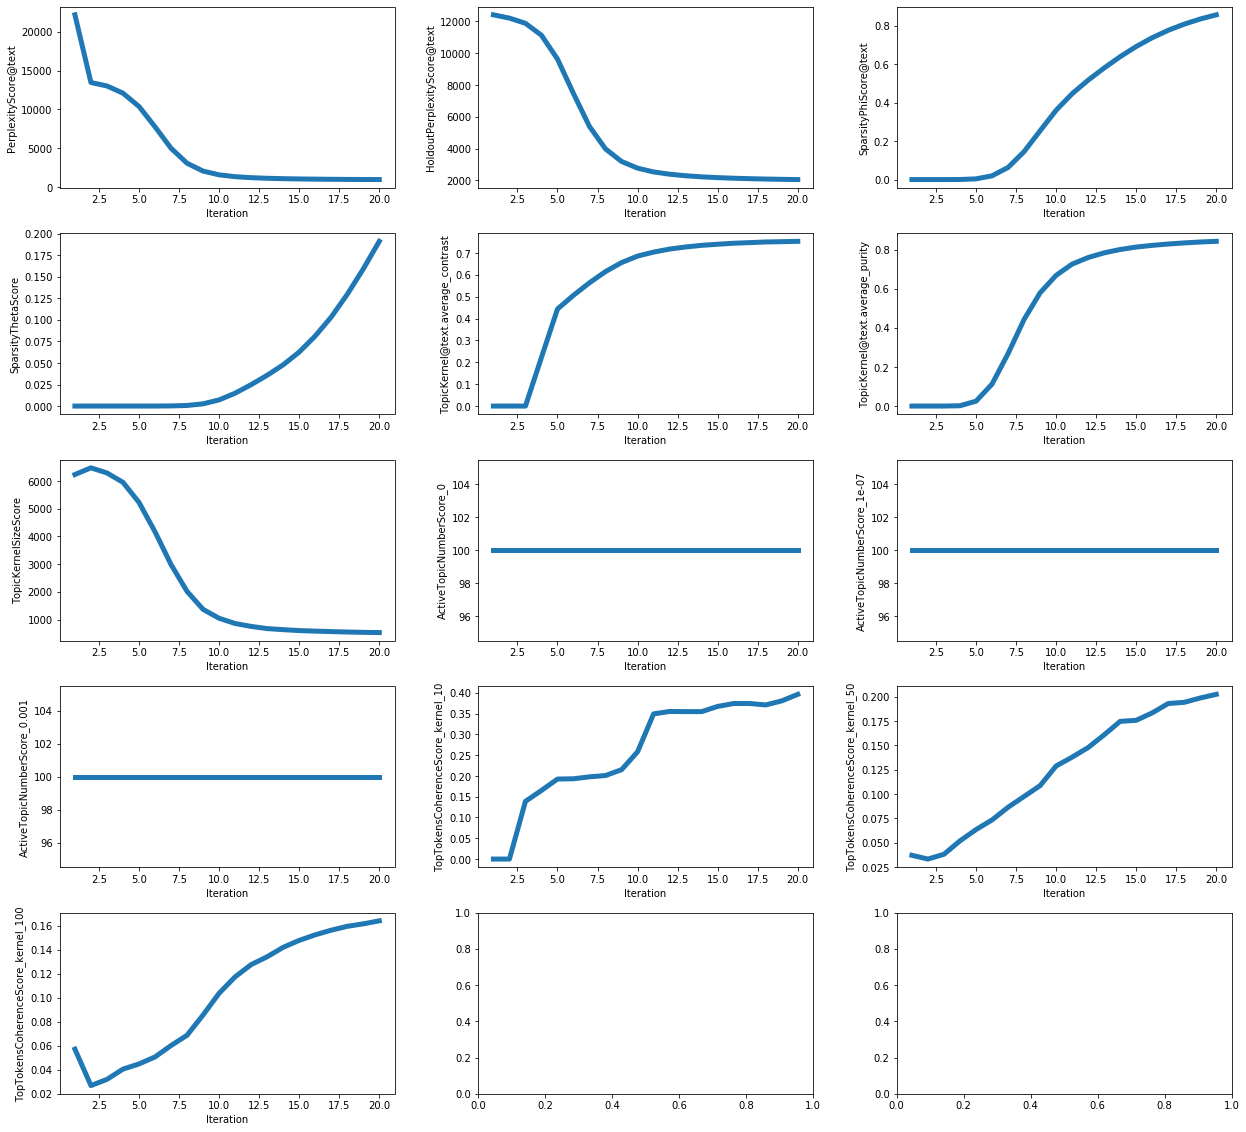

In [ ]:
draw_plots(best_model, num_cols=3)

Both perplexities descrease; coherence, purity and contrast increase — it is generally a good sign.

In [ ]:
del models
del best_model

### Topic Selection<a id="fixing-topic-selection"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

* https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html#topic-selection-theta

In [ ]:
selecting_regularizer_parameters = {
    'regularizer': artm.TopicSelectionThetaRegularizer(
        tau=0,
        name=SELECT_TOPICS,
        topic_names=SPECIFIC_TOPIC_NAMES
    ),
    'tau_grid': [0.01, 0.1, 0.2, 0.5, 0.8, 1.0, 1.5, 2.0]
}

selecting_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=selecting_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [ ]:
selecting_cube.parameters

[{'object': <artm.regularizers.TopicSelectionThetaRegularizer at 0x7fab23fb6908>,
  'field': 'tau',
  'values': [0.01, 0.1, 0.2, 0.5, 0.8, 1.0, 1.5, 2.0]}]

In [ ]:
enable_hide_warnings()

topic_model = initialize_topic_model()

To toggle on/off output_stderr, click here .

In [ ]:
%%time

enable_hide_warnings()

models = selecting_cube(topic_model, dataset)

To toggle on/off output_stderr, click here .

CPU times: user 27min 25s, sys: 1min 41s, total: 29min 6s
Wall time: 23min


In [ ]:
enable_hide_warnings()

best_model, SELECTION_TAU = select_best_model(
    topic_model.experiment,
    CRITERION,
    SELECT_TOPICS
)

To toggle on/off output_stderr, click here .

PerplexityScore@text -> min COLLECT 1

Holdout perplexity: 2115.320
Perplexity: 993.395
Coherence 10: 0.406
Coherence 50: 0.199
Coherence 100: 0.164
Active topics number: 100.000

Tau: 0.01


We can see, that the best tau leads to the fact, that all topics remain, none was thrown away.
Maybe better would be to leave tau as is, but for demonstration purposes let's choose such tau, which is closest to the best one, but which actually helps to select topics.

Another way would be try to increase the number of topics in a model `NUM_SPECIFIC_TOPICS`: maybe than regularizer will work with any tau, even with small ones, but this approach was not tested.

In [ ]:
enable_hide_warnings()

for m in models:
    show_scores(m, SCORES)
    print('Tau:', m.restore().regularizers[SELECT_TOPICS].tau)
    print()

To toggle on/off output_stderr, click here .

PerplexityScore@text                        993.395
HoldoutPerplexityScore@text                2115.320
SparsityPhiScore@text                         0.799
SparsityThetaScore                            0.071
TopicKernel@text.average_contrast             0.749
TopicKernel@text.average_purity               0.819
TopicKernelSizeScore                        555.500
ActiveTopicNumberScore_0                    100.000
ActiveTopicNumberScore_1e-07                100.000
ActiveTopicNumberScore_0.001                100.000
TopTokensCoherenceScore_kernel_10             0.406
TopTokensCoherenceScore_kernel_50             0.199
TopTokensCoherenceScore_kernel_100            0.164
Tau: 0.01

PerplexityScore@text                        993.420
HoldoutPerplexityScore@text                2115.154
SparsityPhiScore@text                         0.799
SparsityThetaScore                            0.071
TopicKernel@text.average_contrast             0.749
TopicKernel@text.average_purity               0.820
T

So, one can see, that the wanted tau is `0.5`: it selects topics.
Perplexity increases, but not much (with next tau `0.8` perplexity already nearly twice as big, as with the previously found best tau `0.1`)

In [ ]:
enable_hide_warnings()

SELECTION_TAU = 0.5

best_model = [m for m in models if m.restore().regularizers[SELECT_TOPICS].tau == SELECTION_TAU][0]
best_model = best_model.restore()

To toggle on/off output_stderr, click here .

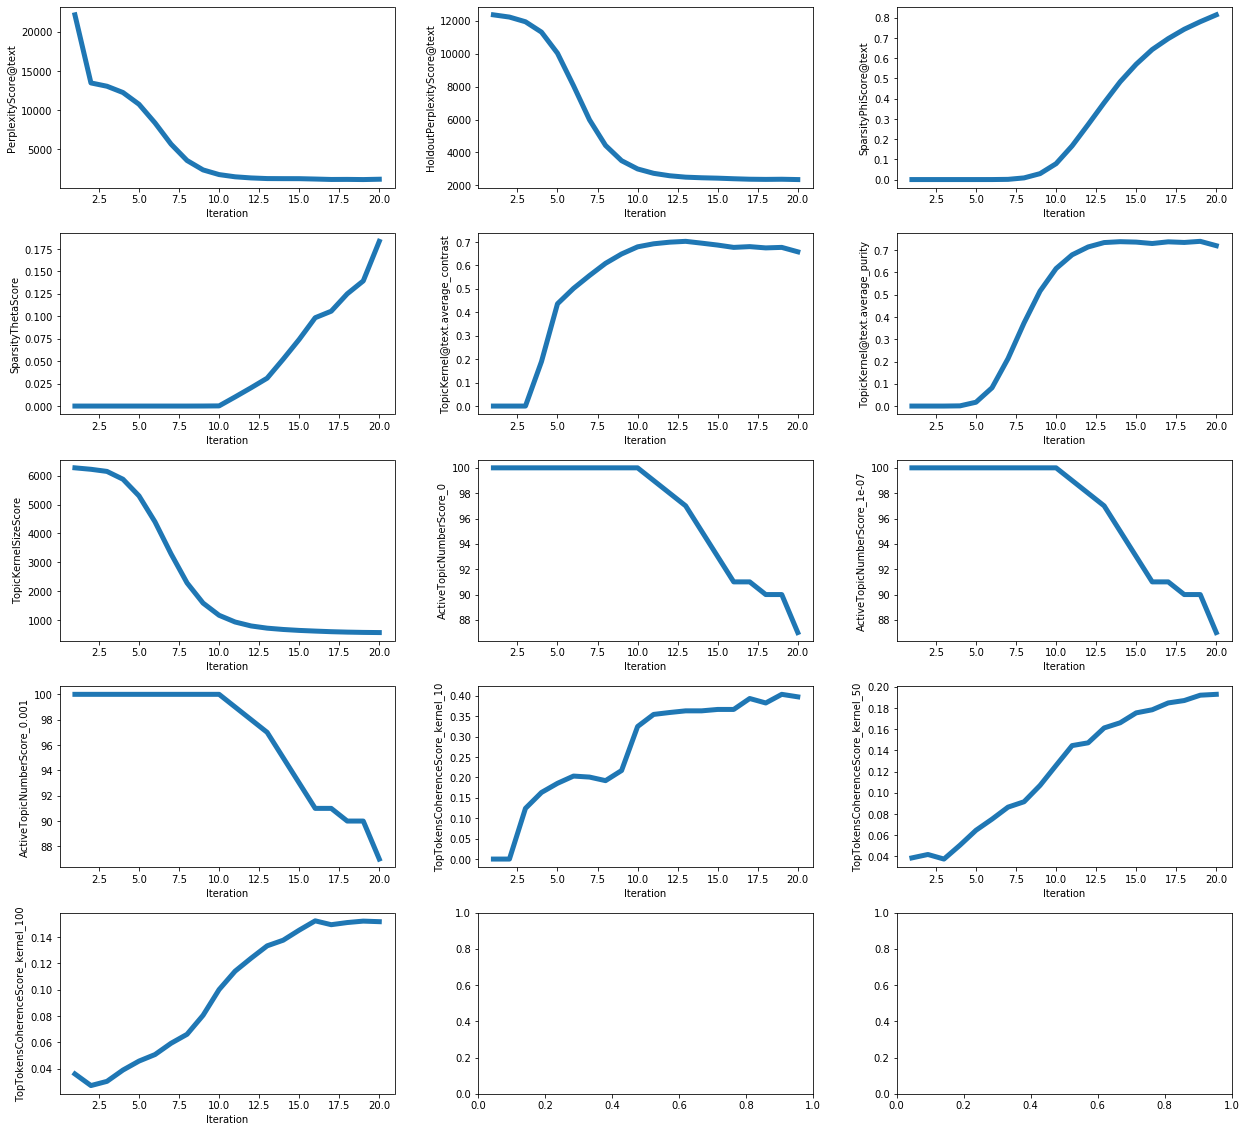

In [ ]:
draw_plots(best_model, num_cols=3)

One may look at the best model's Phi matrix

In [ ]:
best_model.get_phi().head()

spec_topic_0  spec_topic_1  spec_topic_2  spec_topic_3  \
modality token                                                                
@text    imp                  0.0           0.0           0.0           0.0   
         slouch               0.0           0.0           0.0           0.0   
         celebrates           0.0           0.0           0.0           0.0   
         mica                 0.0           0.0           0.0           0.0   
         dancer               0.0           0.0           0.0           0.0   

                     spec_topic_4  spec_topic_5  spec_topic_6  spec_topic_7  \
modality token                                                                
@text    imp                  0.0           0.0           0.0           0.0   
         slouch               0.0           0.0           0.0           0.0   
         celebrates           0.0           0.0           0.0           0.0   
         mica                 0.0           0.0           0.0           0.0   
         dancer               0.0           0.0           0.0           0.0   

                     spec_topic_8  spec_topic_9  ...  spec_topic_92  \
modality token                                   ...                  
@text    imp                  0.0           0.0  ...            0.0   
         slouch               0.0           0.0  ...            0.0   
         celebrates           0.0           0.0  ...            0.0   
         mica                 0.0           0.0  ...            0.0   
         dancer               0.0           0.0  ...            0.0   

                     spec_topic_93  spec_topic_94  spec_topic_95  \
modality token                                                     
@text    imp                   0.0            0.0            0.0   
         slouch                0.0            0.0            0.0   
         celebrates            0.0            0.0            0.0   
         mica                  0.0            0.0            0.0   
         dancer                0.0            0.0            0.0   

                     spec_topic_96  spec_topic_97  spec_topic_98  \
modality token                                                     
@text    imp                   0.0            0.0   0.000000e+00   
         slouch                0.0            0.0   0.000000e+00   
         celebrates            0.0            0.0   4.143302e-14   
         mica                  0.0            0.0   2.050688e-13   
         dancer                0.0            0.0   0.000000e+00   

                     spec_topic_99  back_topic_0  back_topic_1  
modality token                                                  
@text    imp                   0.0           0.0      0.000000  
         slouch                0.0           0.0      0.000000  
         celebrates            0.0           0.0      0.000350  
         mica                  0.0           0.0      0.001751  
         dancer                0.0           0.0      0.000000  

[5 rows x 102 columns]

And top tokens of one of the topics

In [ ]:
if 'spec_topic_0' in best_model.get_phi().columns:
    print(best_model.get_phi()['spec_topic_0'].sort_values(ascending=False)[:20])

modality  token            
@text     lebanese             0.029335
          allah                0.017046
          infrastructure       0.013951
          telecommunication    0.013907
          nist                 0.013429
          balanced             0.012968
          sampling             0.012262
          tension              0.012109
          authorization        0.011630
          muhammad             0.011496
          syrian               0.011496
          guerilla             0.011100
          microcircuit         0.011100
          gui                  0.009904
          csrc                 0.009514
          neck                 0.009372
          unauthorized         0.008897
          evaluate             0.008807
          withdraw             0.008719
          prophethood          0.008325
Name: spec_topic_0, dtype: float32


In [ ]:
del models
del best_model

### Sparsing<a id="fixing-sparsing"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

* https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html#smooth-sparse-phi

In [ ]:
sparsing_regularizer_parameters = {
    'regularizer': artm.SmoothSparsePhiRegularizer(
        tau=0,
        name=SPARSE_PHI_SPECIFIC,
        topic_names=SPECIFIC_TOPIC_NAMES,
        class_ids=[MODALITY]
    ),
    'tau_grid': [-10, -1, -0.2, -0.1, -0.02, -0.01, -0.001]
}

sparsing_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=sparsing_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [ ]:
sparsing_cube.parameters

[{'object': <artm.regularizers.SmoothSparsePhiRegularizer at 0x7fabb4d2b400>,
  'field': 'tau',
  'values': [-10, -1, -0.2, -0.1, -0.02, -0.01, -0.001]}]

In [ ]:
topic_model = initialize_topic_model()

In [ ]:
%%time

models = sparsing_cube(topic_model, dataset)

CPU times: user 24min 28s, sys: 56.5 s, total: 25min 24s
Wall time: 20min 56s


*Remark*. If one try to select best model by `TopTokensCoherenceScore`, she will get the model with almost all top token probabilities equal to zero.
This may be the drawback of the coherence score.
So `PerplexityScore` should be used here for finding the best tau for Sparsing regularizer (regardless of what the value of `WITH_COOCS` is).

In [ ]:
enable_hide_warnings()

best_model, SPARSING_TAU = select_best_model(
    topic_model.experiment,
    PERPLEXITY_CRITERION,
    SPARSE_PHI_SPECIFIC
)

To toggle on/off output_stderr, click here .

PerplexityScore@text -> min COLLECT 1

Holdout perplexity: 2085.935
Perplexity: 1012.688
Coherence 10: 0.374
Coherence 50: 0.193
Coherence 100: 0.159
Active topics number: 100.000

Tau: -0.001


In [ ]:
SPARSING_TAU

-0.001

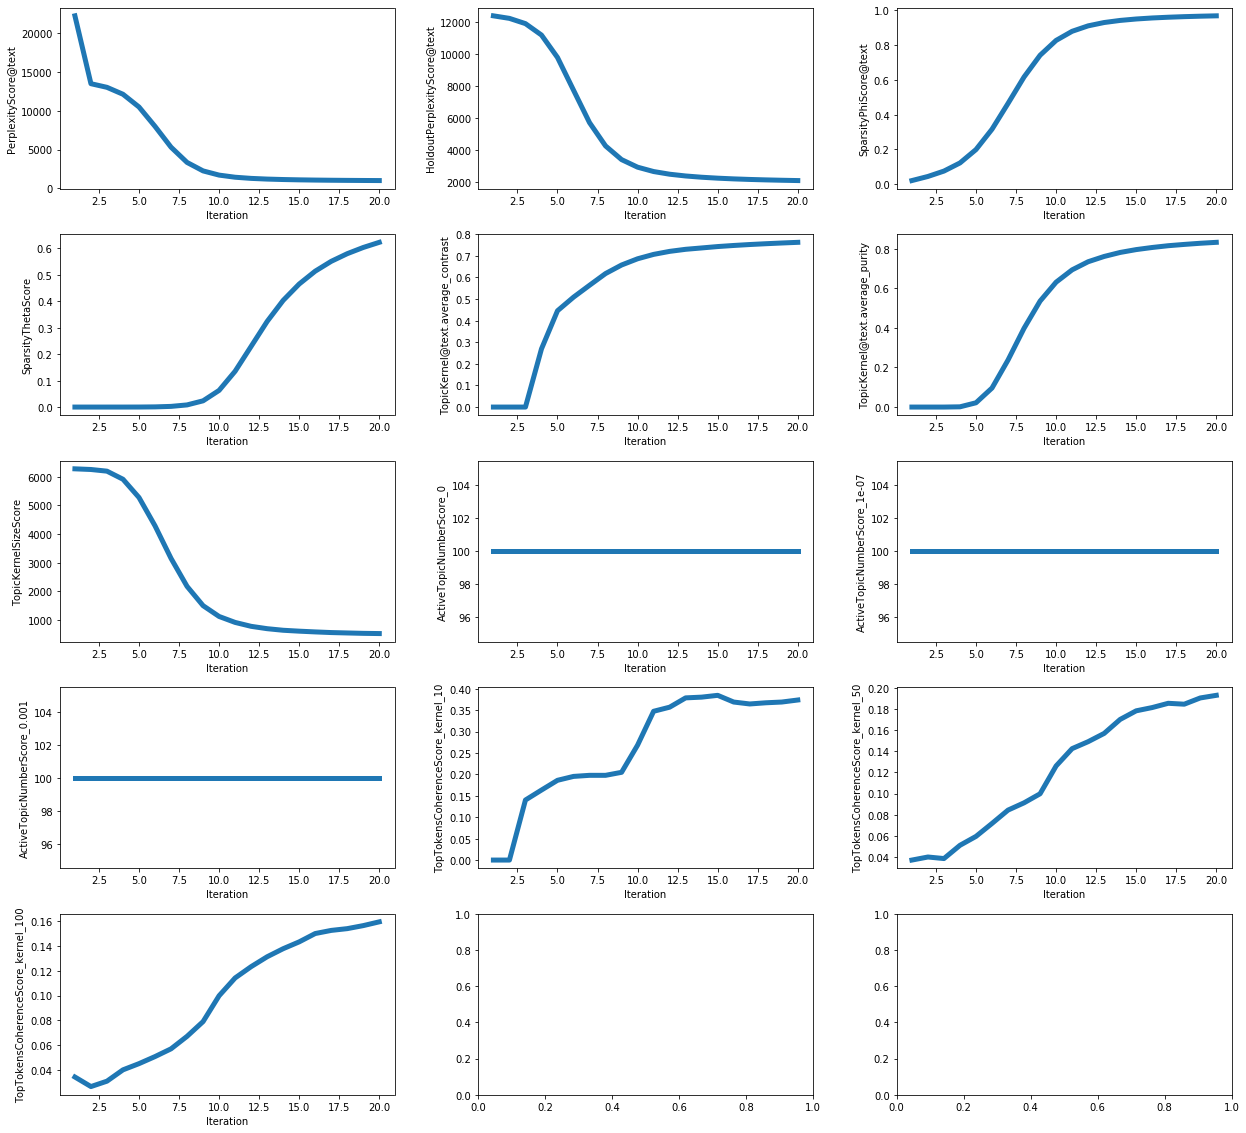

In [ ]:
draw_plots(best_model, num_cols=3)

In [ ]:
del models
del best_model

### Best Parameters<a id="best-parameters"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Let's fix found taus

In [ ]:
best_decorrelating_regularizer_parameters = {
    'regularizer': artm.DecorrelatorPhiRegularizer(
        tau=0,
        name=DECORRELATE_SPECIFIC,
        topic_names=SPECIFIC_TOPIC_NAMES,
        class_ids=[MODALITY],
    ),
    'tau_grid': [DECORRELATION_TAU]
}

best_decorrelating_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=best_decorrelating_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)


best_selecting_regularizer_parameters = {
    'regularizer': artm.TopicSelectionThetaRegularizer(
        tau=0,
        name=SELECT_TOPICS,
        topic_names=SPECIFIC_TOPIC_NAMES
    ),
    'tau_grid': [SELECTION_TAU]
}

best_selecting_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=best_selecting_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)


best_sparsing_regularizer_parameters = {
    'regularizer': artm.SmoothSparsePhiRegularizer(
        tau=0,
        name=SPARSE_PHI_SPECIFIC,
        topic_names=SPECIFIC_TOPIC_NAMES,
        class_ids=[MODALITY]
    ),
    'tau_grid': [SPARSING_TAU]
}

best_sparsing_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=best_sparsing_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

## Combining Regularizers in Different Ways<a id="combining-regularizers"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Here we will try different combinations of regularizers in search of a good model

### Decorrelation, Topic Selection<a id="decorr-select"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
enable_hide_warnings()

topic_model = initialize_topic_model()

To toggle on/off output_stderr, click here .

In [ ]:
topic_model._model.regularizers

[sparse_phi_specific, sparse_theta_specific, smooth_phi_background, smooth_theta_background, decorrelate_specific, decorrelate_background, select_topics]

In [ ]:
topic_model._model.regularizers[DECORRELATE_SPECIFIC].tau

0

Setting decorrelation tau to found non-zero value

In [ ]:
topic_model._model.regularizers[DECORRELATE_SPECIFIC].tau = DECORRELATION_TAU

topic_model._fit(dataset.get_batch_vectorizer(), NUM_CUBE_ITERATIONS)

In [ ]:
topic_model._model.regularizers[DECORRELATE_SPECIFIC].tau

10000.0

And now turning the regularizer back off

In [ ]:
topic_model._model.regularizers[DECORRELATE_SPECIFIC].tau = 0

In [ ]:
topic_model._model.regularizers[SELECT_TOPICS].tau

0

Turning on another regularizer

In [ ]:
topic_model._model.regularizers[SELECT_TOPICS].tau = SELECTION_TAU

In [ ]:
topic_model._model.regularizers[SELECT_TOPICS].tau

0.5

In [ ]:
topic_model._fit(dataset.get_batch_vectorizer(), NUM_CUBE_ITERATIONS)

In [ ]:
topic_model._model.regularizers[SELECT_TOPICS].tau

0.5

In [ ]:
topic_model._model.regularizers[SELECT_TOPICS].tau = 0

And sparsing in the end

In [ ]:
topic_model._model.regularizers[SPARSE_PHI_SPECIFIC].tau

0

In [ ]:
topic_model._model.regularizers[SPARSE_PHI_SPECIFIC].tau = SPARSING_TAU

In [ ]:
topic_model._fit(dataset.get_batch_vectorizer(), NUM_CUBE_ITERATIONS)

In [ ]:
topic_model._model.regularizers[SPARSE_PHI_SPECIFIC].tau

-0.001

In [ ]:
topic_model._model.regularizers[SPARSE_PHI_SPECIFIC].tau = 0

Let's look what we got

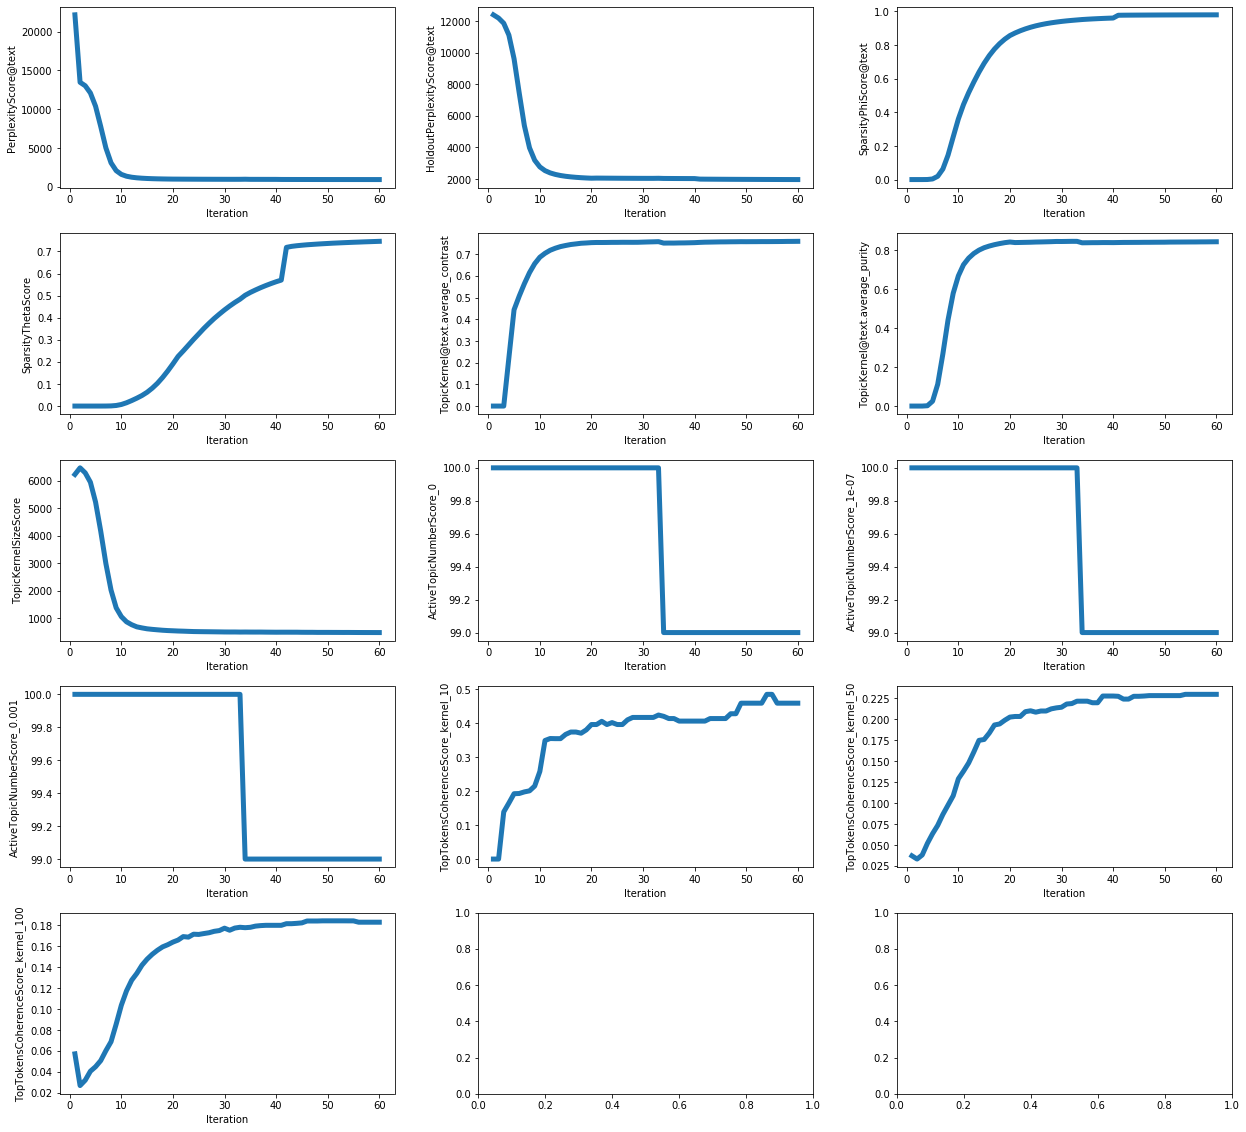

In [ ]:
draw_plots(topic_model, num_cols=3)

In [ ]:
show_scores(topic_model, SCORES)

PerplexityScore@text                        915.976
HoldoutPerplexityScore@text                1964.934
SparsityPhiScore@text                         0.979
SparsityThetaScore                            0.746
TopicKernel@text.average_contrast             0.759
TopicKernel@text.average_purity               0.843
TopicKernelSizeScore                        466.500
ActiveTopicNumberScore_0                     99.000
ActiveTopicNumberScore_1e-07                 99.000
ActiveTopicNumberScore_0.001                 99.000
TopTokensCoherenceScore_kernel_10             0.459
TopTokensCoherenceScore_kernel_50             0.230
TopTokensCoherenceScore_kernel_100            0.183


In [ ]:
del topic_model

### Topic Selection, Decorrelation<a id="select-decorr"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
enable_hide_warnings()

topic_model = initialize_topic_model()

To toggle on/off output_stderr, click here .

A compact version of what was done in the previous section (only with changed order of the regularizers)

In [ ]:
%%time

topic_model._model.regularizers[SELECT_TOPICS].tau = SELECTION_TAU
topic_model._fit(dataset.get_batch_vectorizer(), NUM_CUBE_ITERATIONS)
topic_model._model.regularizers[SELECT_TOPICS].tau = 0

topic_model._model.regularizers[DECORRELATE_SPECIFIC].tau = DECORRELATION_TAU
topic_model._fit(dataset.get_batch_vectorizer(), NUM_CUBE_ITERATIONS)
topic_model._model.regularizers[DECORRELATE_SPECIFIC].tau = 0

topic_model._model.regularizers[SPARSE_PHI_SPECIFIC].tau = SPARSING_TAU
topic_model._fit(dataset.get_batch_vectorizer(), NUM_CUBE_ITERATIONS)
topic_model._model.regularizers[SPARSE_PHI_SPECIFIC].tau = 0

CPU times: user 6min 42s, sys: 27.5 s, total: 7min 9s
Wall time: 5min 34s


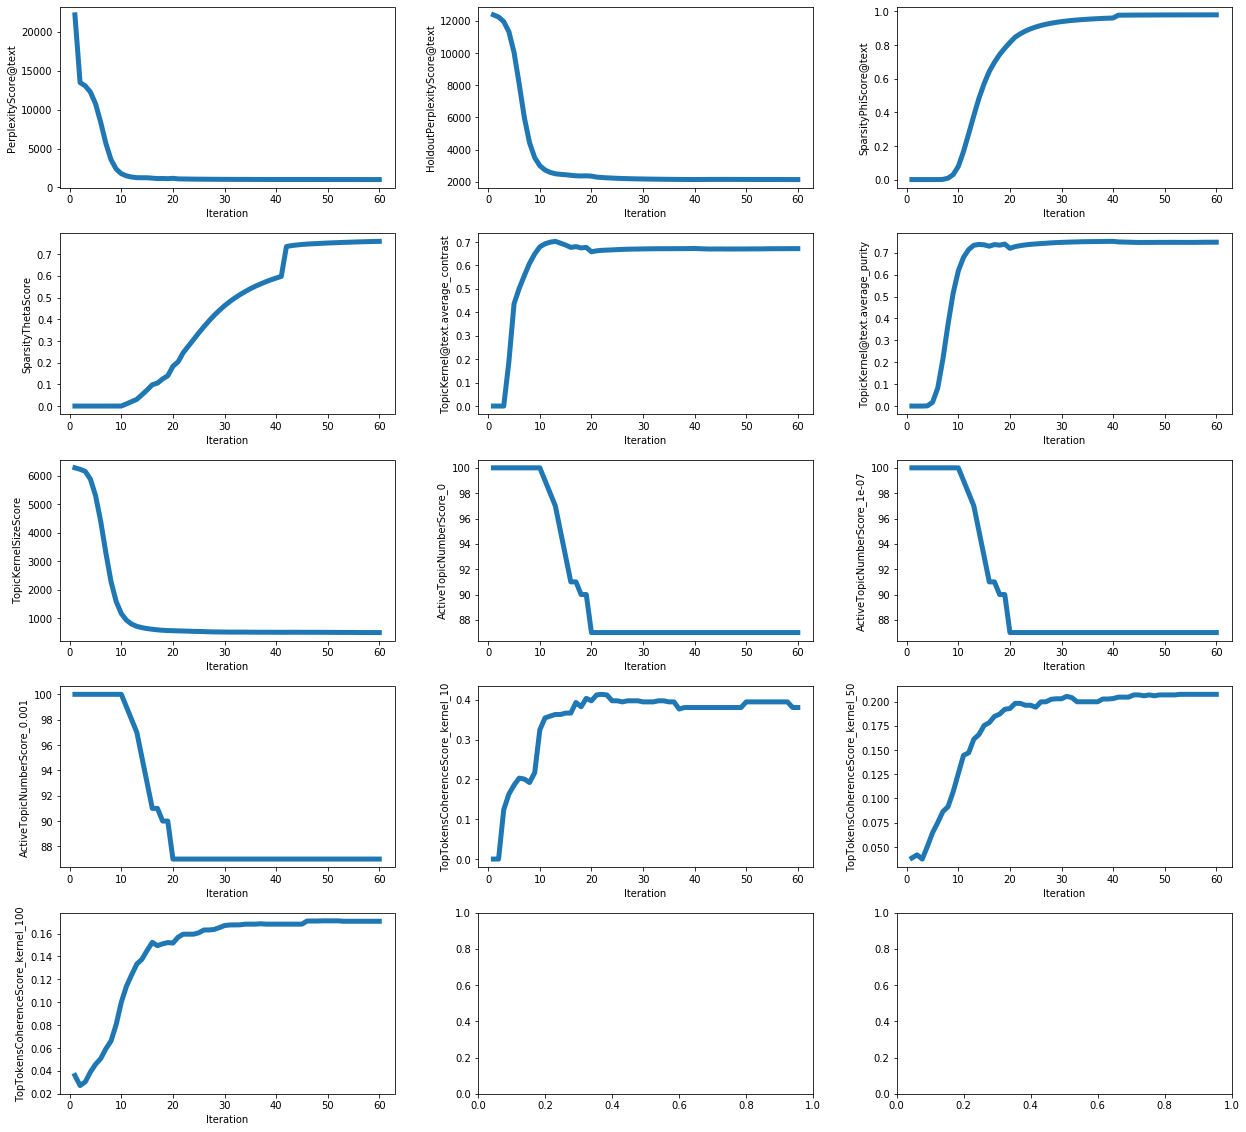

In [ ]:
draw_plots(topic_model, num_cols=3)

In [ ]:
show_scores(topic_model, SCORES)

PerplexityScore@text                       1009.656
HoldoutPerplexityScore@text                2139.785
SparsityPhiScore@text                         0.979
SparsityThetaScore                            0.759
TopicKernel@text.average_contrast             0.671
TopicKernel@text.average_purity               0.748
TopicKernelSizeScore                        499.500
ActiveTopicNumberScore_0                     87.000
ActiveTopicNumberScore_1e-07                 87.000
ActiveTopicNumberScore_0.001                 87.000
TopTokensCoherenceScore_kernel_10             0.381
TopTokensCoherenceScore_kernel_50             0.208
TopTokensCoherenceScore_kernel_100            0.171


In [ ]:
del topic_model

### Decorrelation with Topic Selection (Short)<a id="decorr-with-select-short"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
enable_hide_warnings()

topic_model = initialize_topic_model()

To toggle on/off output_stderr, click here .

In [ ]:
%%time

topic_model._model.regularizers[SELECT_TOPICS].tau = SELECTION_TAU
topic_model._model.regularizers[DECORRELATE_SPECIFIC].tau = DECORRELATION_TAU

topic_model._fit(dataset.get_batch_vectorizer(), NUM_CUBE_ITERATIONS)

topic_model._model.regularizers[SELECT_TOPICS].tau = 0
topic_model._model.regularizers[DECORRELATE_SPECIFIC].tau = 0
topic_model._model.regularizers[SPARSE_PHI_SPECIFIC].tau = SPARSING_TAU

topic_model._fit(dataset.get_batch_vectorizer(), NUM_CUBE_ITERATIONS)

topic_model._model.regularizers[SPARSE_PHI_SPECIFIC].tau = 0

CPU times: user 4min 25s, sys: 8.82 s, total: 4min 33s
Wall time: 3min 45s


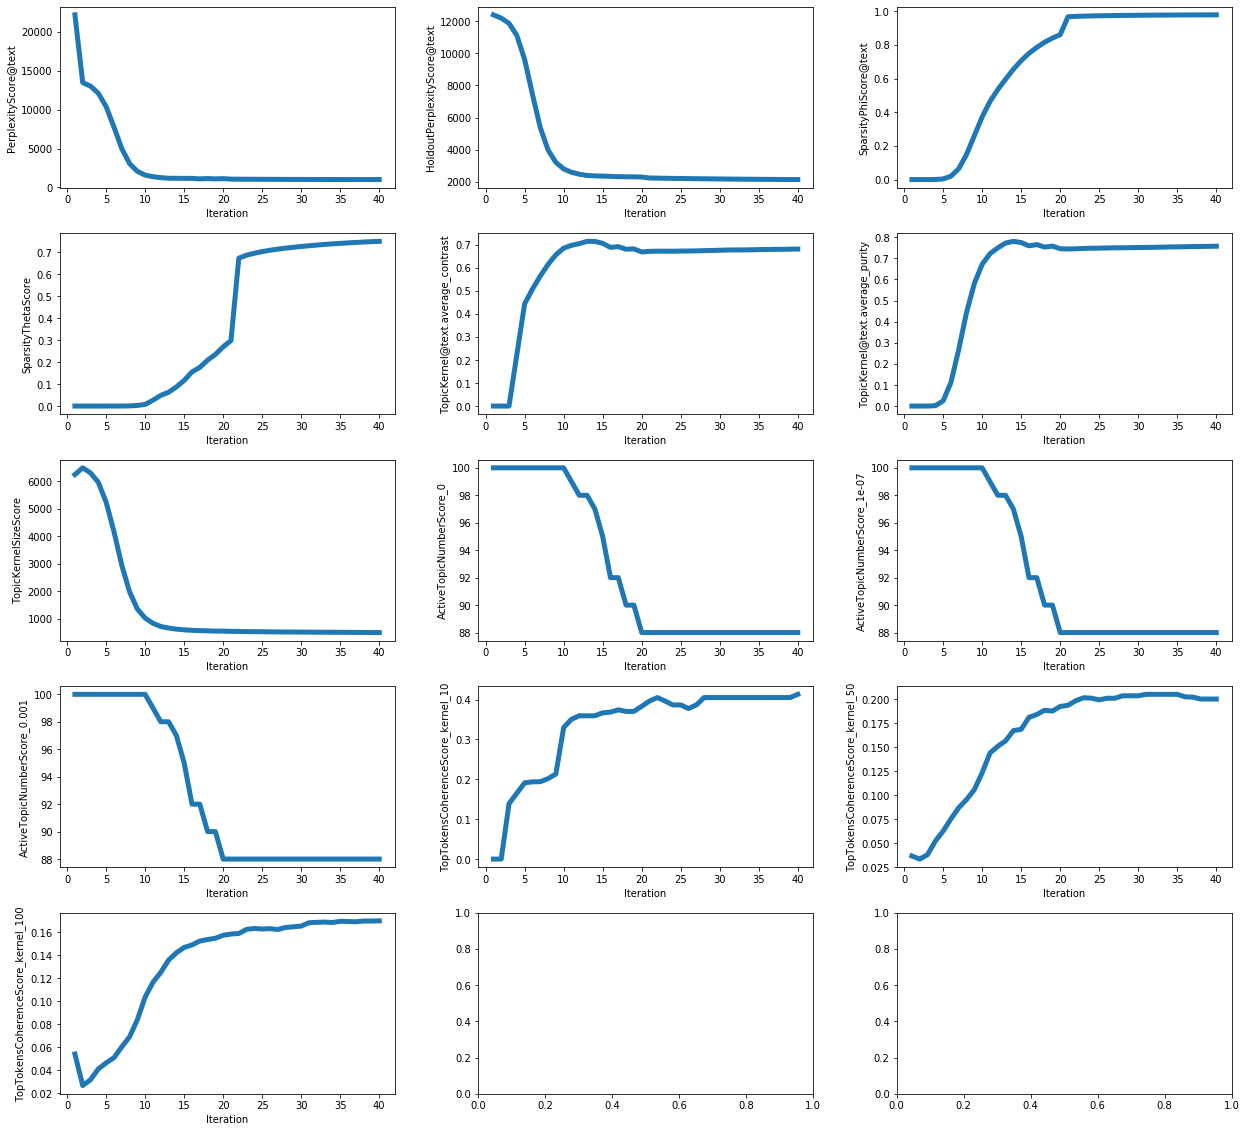

In [ ]:
draw_plots(topic_model, num_cols=3)

In [ ]:
show_scores(topic_model, SCORES)

PerplexityScore@text                       1015.950
HoldoutPerplexityScore@text                2133.948
SparsityPhiScore@text                         0.978
SparsityThetaScore                            0.748
TopicKernel@text.average_contrast             0.681
TopicKernel@text.average_purity               0.757
TopicKernelSizeScore                        498.500
ActiveTopicNumberScore_0                     88.000
ActiveTopicNumberScore_1e-07                 88.000
ActiveTopicNumberScore_0.001                 88.000
TopTokensCoherenceScore_kernel_10             0.413
TopTokensCoherenceScore_kernel_50             0.200
TopTokensCoherenceScore_kernel_100            0.170


In [ ]:
del topic_model

### Decorrelation with Topic Selection (Long)<a id="decorr-with-select-long"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [ ]:
enable_hide_warnings()

topic_model = initialize_topic_model()

To toggle on/off output_stderr, click here .

In [ ]:
%%time

topic_model._model.regularizers[SELECT_TOPICS].tau = SELECTION_TAU
topic_model._model.regularizers[DECORRELATE_SPECIFIC].tau = DECORRELATION_TAU

topic_model._fit(dataset.get_batch_vectorizer(), 2 * NUM_CUBE_ITERATIONS)

topic_model._model.regularizers[SELECT_TOPICS].tau = 0
topic_model._model.regularizers[DECORRELATE_SPECIFIC].tau = 0
topic_model._model.regularizers[SPARSE_PHI_SPECIFIC].tau = SPARSING_TAU

topic_model._fit(dataset.get_batch_vectorizer(), NUM_CUBE_ITERATIONS)

topic_model._model.regularizers[SPARSE_PHI_SPECIFIC].tau = 0

CPU times: user 6min 35s, sys: 16.2 s, total: 6min 51s
Wall time: 5min 38s


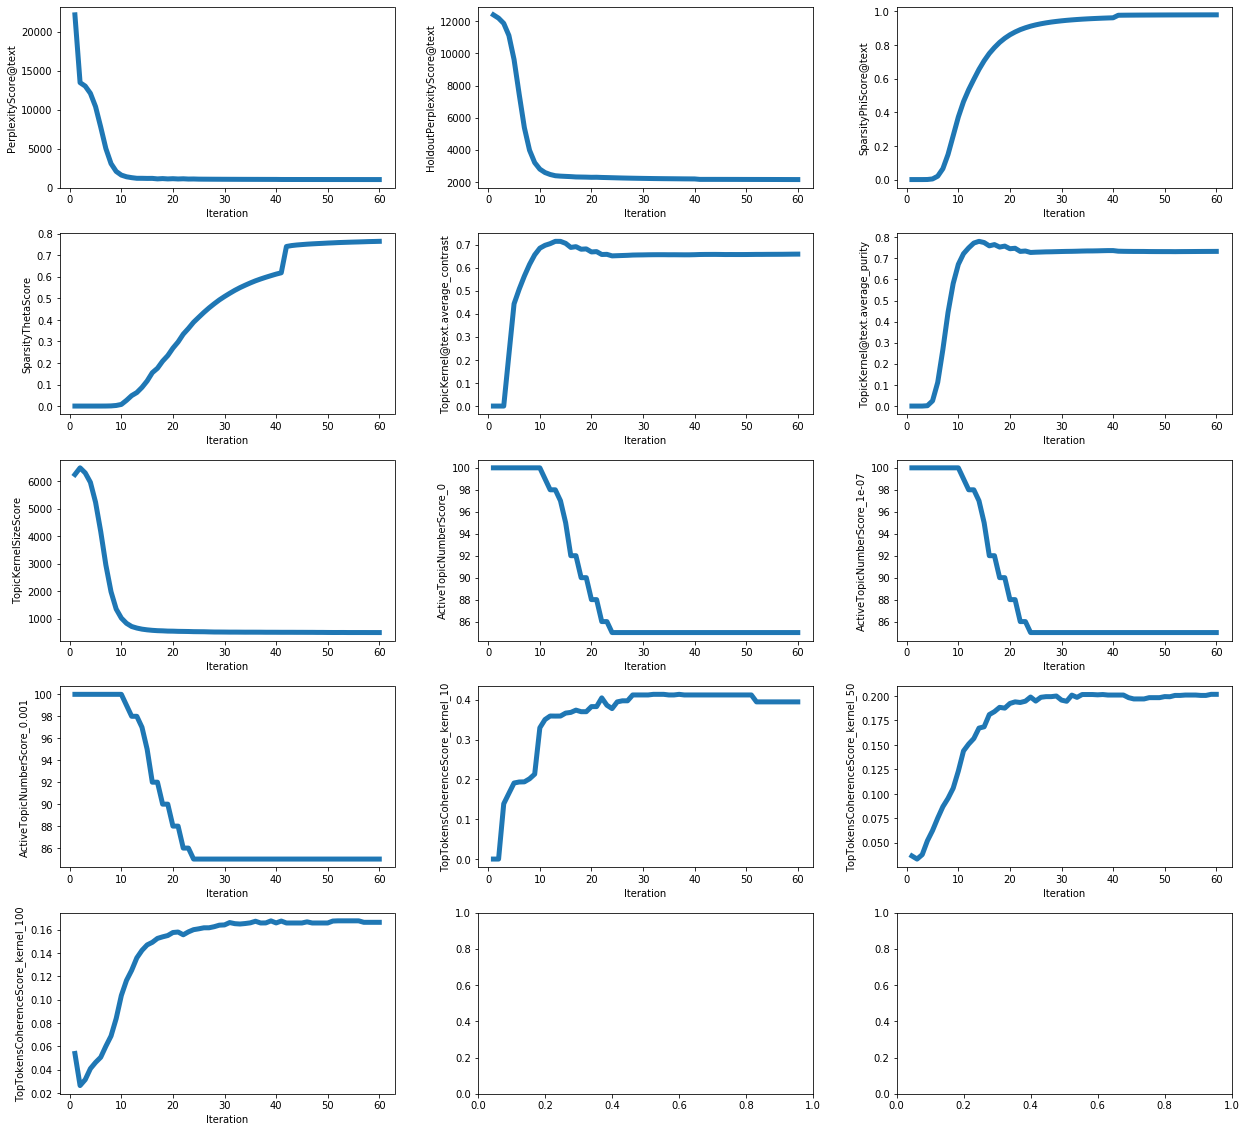

In [ ]:
draw_plots(topic_model, num_cols=3)

In [ ]:
show_scores(topic_model, SCORES)

PerplexityScore@text                       1020.306
HoldoutPerplexityScore@text                2151.106
SparsityPhiScore@text                         0.979
SparsityThetaScore                            0.765
TopicKernel@text.average_contrast             0.659
TopicKernel@text.average_purity               0.733
TopicKernelSizeScore                        499.000
ActiveTopicNumberScore_0                     85.000
ActiveTopicNumberScore_1e-07                 85.000
ActiveTopicNumberScore_0.001                 85.000
TopTokensCoherenceScore_kernel_10             0.395
TopTokensCoherenceScore_kernel_50             0.202
TopTokensCoherenceScore_kernel_100            0.166


In [ ]:
del topic_model

### Sophisticated. All at Once but One after Another<a id="sophisticated-one-after-another"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Here go a couple of more complex ways to combine regularizers.
In fact, next ten or so cells ("Sophisticated" sections) are the core part of the notebook: to show how TopicNet helps to do quite complex things with ease.

First, let's try to combine all the regularizers at once, but make so that they go one after another, with fixed taus.
This is basically the same thing we did in one of the previous sections, when decorrelation regularizer was the first, then topic selection one, and then sparsing regularizer.
Here, however, we are going to use another, TopicNet, approach in organizing the training process.

In [ ]:
def decorrelation_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return DECORRELATION_TAU
    else:
        return 0.0

def selection_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return 0.0
    elif cur_iter <= 2 * NUM_CUBE_ITERATIONS:
        return SELECTION_TAU
    else:
        return 0.0

def sparsing_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter > 2 * NUM_CUBE_ITERATIONS: 
        return SPARSING_TAU
    else:
        return 0.0

In [ ]:
cube_parameters = [
    {
        'reg_name': DECORRELATE_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MODALITY,  # tracking just usual Perplexity score
        'tau_converter': decorrelation_tau_converter,
        'user_value_grid': [0]                          # we don't need this
    },
    {
        'reg_name': SELECT_TOPICS,
        'score_to_track': PERPLEXITY_SCORE + MODALITY,
        'tau_converter': selection_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SPARSE_PHI_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MODALITY,
        'tau_converter': sparsing_tau_converter,
        'user_value_grid': [0]
    }
]


cube = RegularizationControllerCube(
    num_iter=3 * NUM_CUBE_ITERATIONS,
    parameters=cube_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [ ]:
enable_hide_warnings()

topic_model = initialize_topic_model()

To toggle on/off output_stderr, click here .

In [ ]:
%%time

models = cube(topic_model, dataset)

CPU times: user 10min 39s, sys: 30 s, total: 11min 9s
Wall time: 9min 5s


Only one model as a cube result (because we set previously found taus as parameters)

In [ ]:
topic_model.experiment.models

{'<<<<<<<<<<<root>>>>>>>>>>>': <cooking_machine.models.topic_model.TopicModel at 0x7fac90faa630>,
 '##18h12m44s_08d01m2020y###': <cooking_machine.models.dummy_topic_model.DummyTopicModel at 0x7fab1993c6a0>}

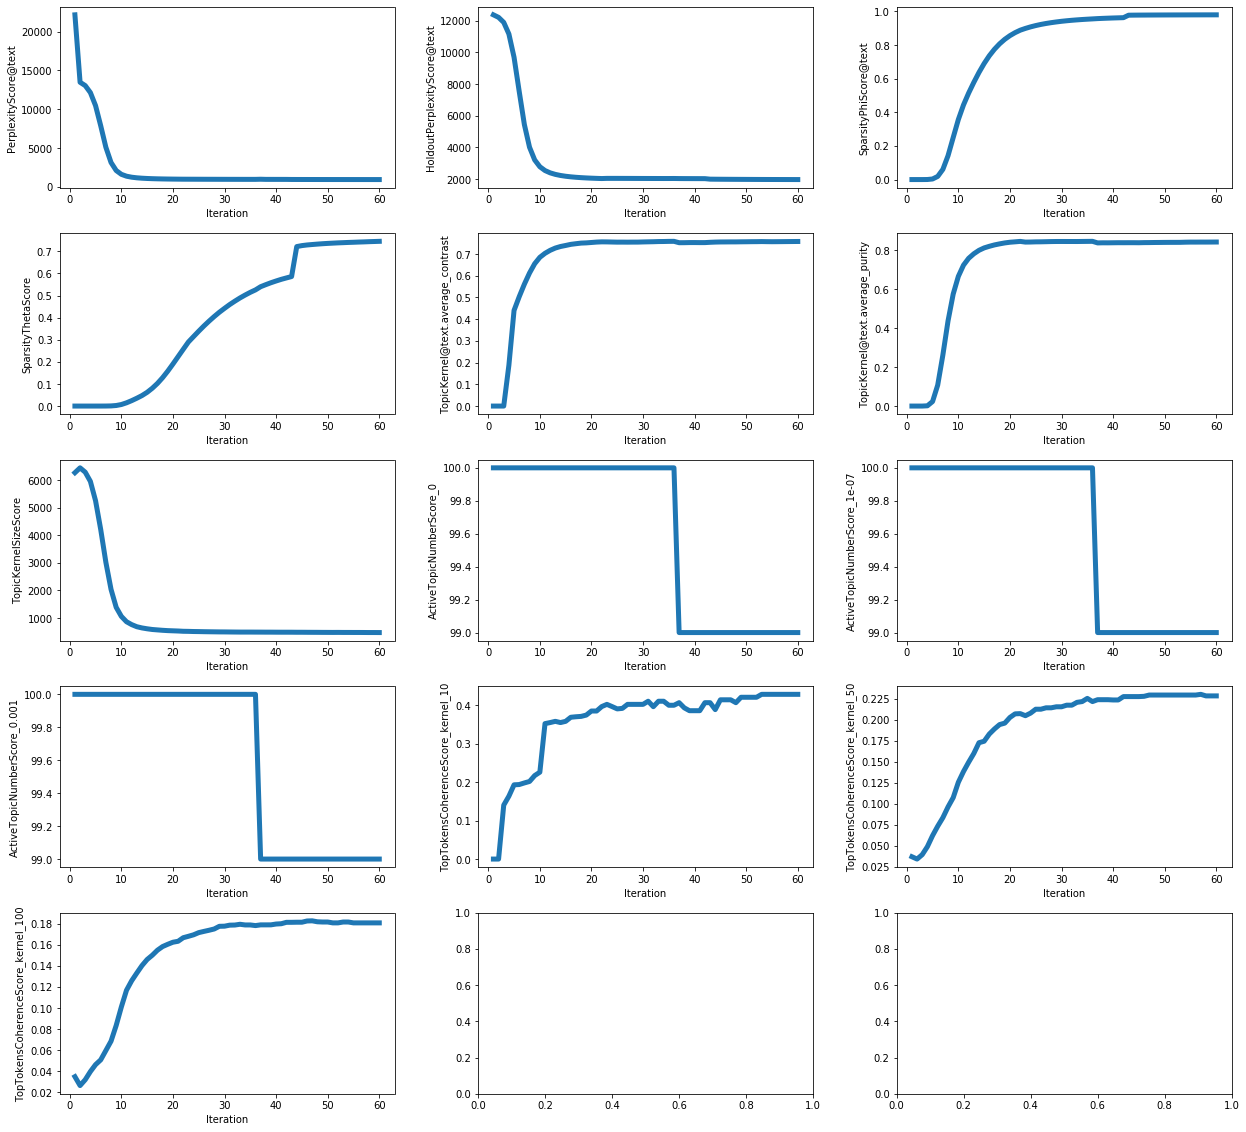

In [ ]:
draw_plots(models[0], num_cols=3)

In [ ]:
show_scores(models[0], SCORES)

PerplexityScore@text                        915.350
HoldoutPerplexityScore@text                1964.099
SparsityPhiScore@text                         0.979
SparsityThetaScore                            0.745
TopicKernel@text.average_contrast             0.758
TopicKernel@text.average_purity               0.843
TopicKernelSizeScore                        468.000
ActiveTopicNumberScore_0                     99.000
ActiveTopicNumberScore_1e-07                 99.000
ActiveTopicNumberScore_0.001                 99.000
TopTokensCoherenceScore_kernel_10             0.428
TopTokensCoherenceScore_kernel_50             0.228
TopTokensCoherenceScore_kernel_100            0.181


In [ ]:
del topic_model

del decorrelation_tau_converter
del selection_tau_converter
del sparsing_tau_converter

del cube_parameters
del cube

### Sophisticated. Changing Parameters<a id="sophisticated-changing"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Regularizer parameters are going to be changed here: taus are gradually increasing starting from some iteration (different for each regularizer).

In [ ]:
def decorrelation_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return cur_iter / NUM_CUBE_ITERATIONS * DECORRELATION_TAU
    else:
        return 0.0

def selection_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return 0.0
    elif cur_iter <= 2 * NUM_CUBE_ITERATIONS:
        return (cur_iter - NUM_CUBE_ITERATIONS) / NUM_CUBE_ITERATIONS * SELECTION_TAU
    else:
        return 0.0

def sparsing_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter > 2 * NUM_CUBE_ITERATIONS: 
        return (cur_iter - 2 * NUM_CUBE_ITERATIONS) / NUM_CUBE_ITERATIONS * SPARSING_TAU
    else:
        return 0.0

In [ ]:
cube_parameters = [
    {
        'reg_name': DECORRELATE_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MODALITY,
        'tau_converter': decorrelation_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SELECT_TOPICS,
        'score_to_track': PERPLEXITY_SCORE + MODALITY,
        'tau_converter': selection_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SPARSE_PHI_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MODALITY,
        'tau_converter': sparsing_tau_converter,
        'user_value_grid': [0]
    }
]

cube = RegularizationControllerCube(
    num_iter=3 * NUM_CUBE_ITERATIONS,
    parameters=cube_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [ ]:
enable_hide_warnings()

topic_model = initialize_topic_model()

To toggle on/off output_stderr, click here .

In [ ]:
%%time

models = cube(topic_model, dataset)

CPU times: user 10min 39s, sys: 38.5 s, total: 11min 18s
Wall time: 9min 1s


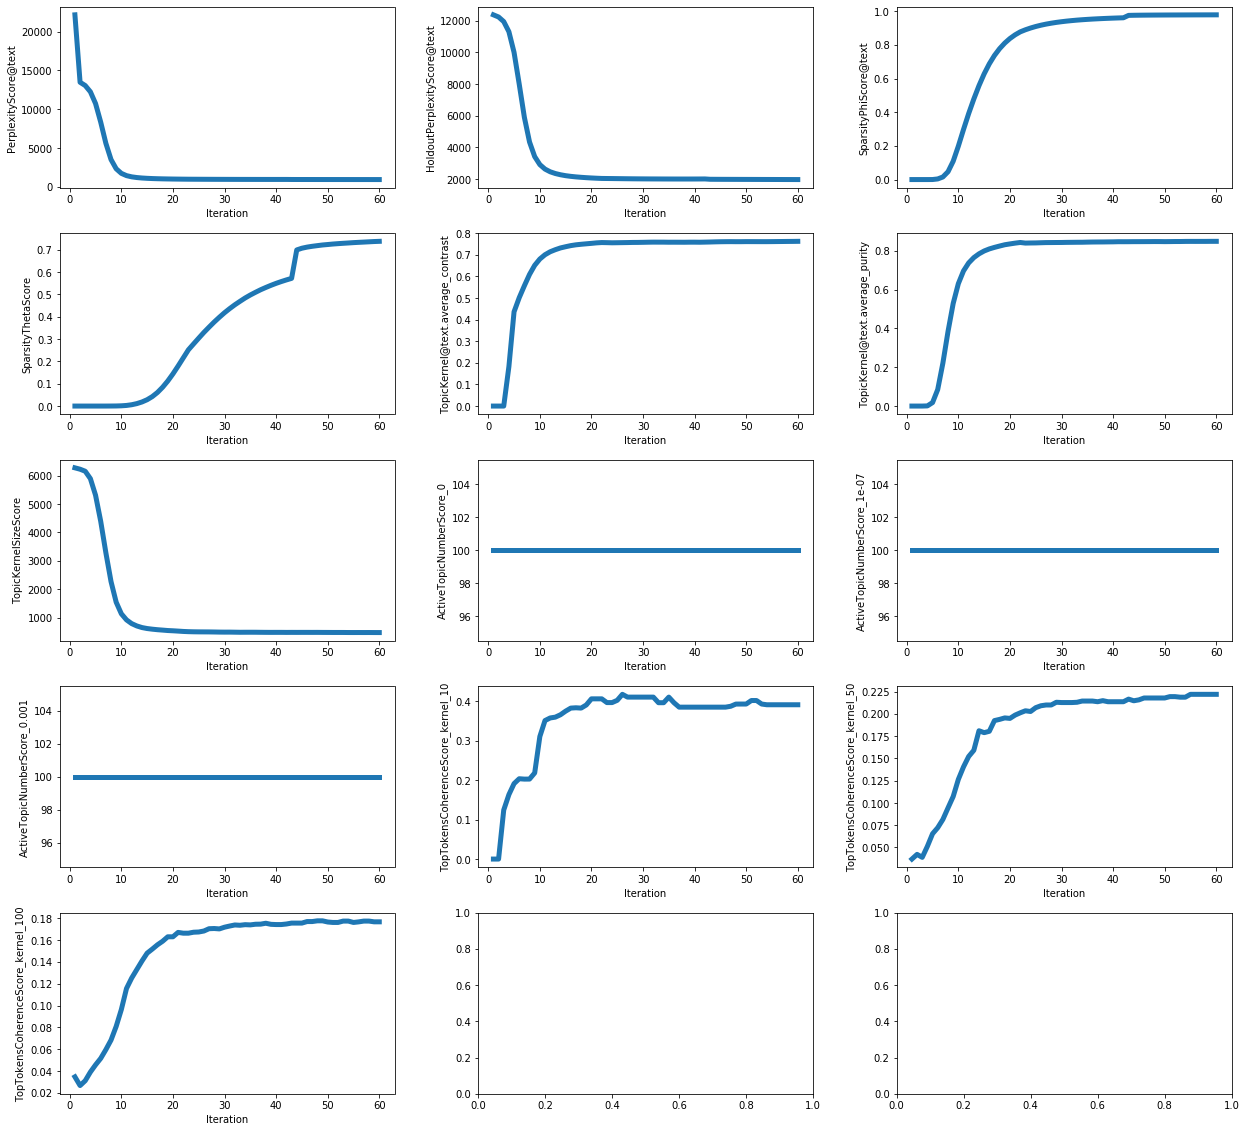

In [ ]:
draw_plots(models[0], num_cols=3)

In [ ]:
show_scores(models[0], SCORES)

PerplexityScore@text                        916.860
HoldoutPerplexityScore@text                1974.262
SparsityPhiScore@text                         0.978
SparsityThetaScore                            0.738
TopicKernel@text.average_contrast             0.762
TopicKernel@text.average_purity               0.849
TopicKernelSizeScore                        479.500
ActiveTopicNumberScore_0                    100.000
ActiveTopicNumberScore_1e-07                100.000
ActiveTopicNumberScore_0.001                100.000
TopTokensCoherenceScore_kernel_10             0.391
TopTokensCoherenceScore_kernel_50             0.222
TopTokensCoherenceScore_kernel_100            0.177


In [ ]:
del topic_model

del decorrelation_tau_converter
del selection_tau_converter
del sparsing_tau_converter

del cube_parameters
del cube

### Sophisticated. Alternating Order<a id="sophisticated-alternating"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Order of regularizers is going to be changed here: on iterations with odd number we decorrelate, on iterations with even number we select topics.

In [ ]:
def decorrelation_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        if cur_iter % 2 == 1:
            return DECORRELATION_TAU
        else:
            return 0.0
    else:
        return 0.0

def selection_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return 0.0
    elif cur_iter <= 2 * NUM_CUBE_ITERATIONS:
        if cur_iter % 2 == 1:
            return 0.0
        else:
            return SELECTION_TAU
    else:
        return 0.0

def sparsing_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter > 2 * NUM_CUBE_ITERATIONS: 
        return SPARSING_TAU
    else:
        return 0.0

In [ ]:
cube_parameters = [
    {
        'reg_name': DECORRELATE_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MODALITY,
        'tau_converter': decorrelation_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SELECT_TOPICS,
        'score_to_track': PERPLEXITY_SCORE + MODALITY,
        'tau_converter': selection_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SPARSE_PHI_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MODALITY,
        'tau_converter': sparsing_tau_converter,
        'user_value_grid': [0]
    }
]

cube = RegularizationControllerCube(
    num_iter=3 * NUM_CUBE_ITERATIONS,
    parameters=cube_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [ ]:
enable_hide_warnings()

topic_model = initialize_topic_model()

To toggle on/off output_stderr, click here .

In [ ]:
%%time

models = cube(topic_model, dataset)

CPU times: user 10min 40s, sys: 35.1 s, total: 11min 15s
Wall time: 9min 2s


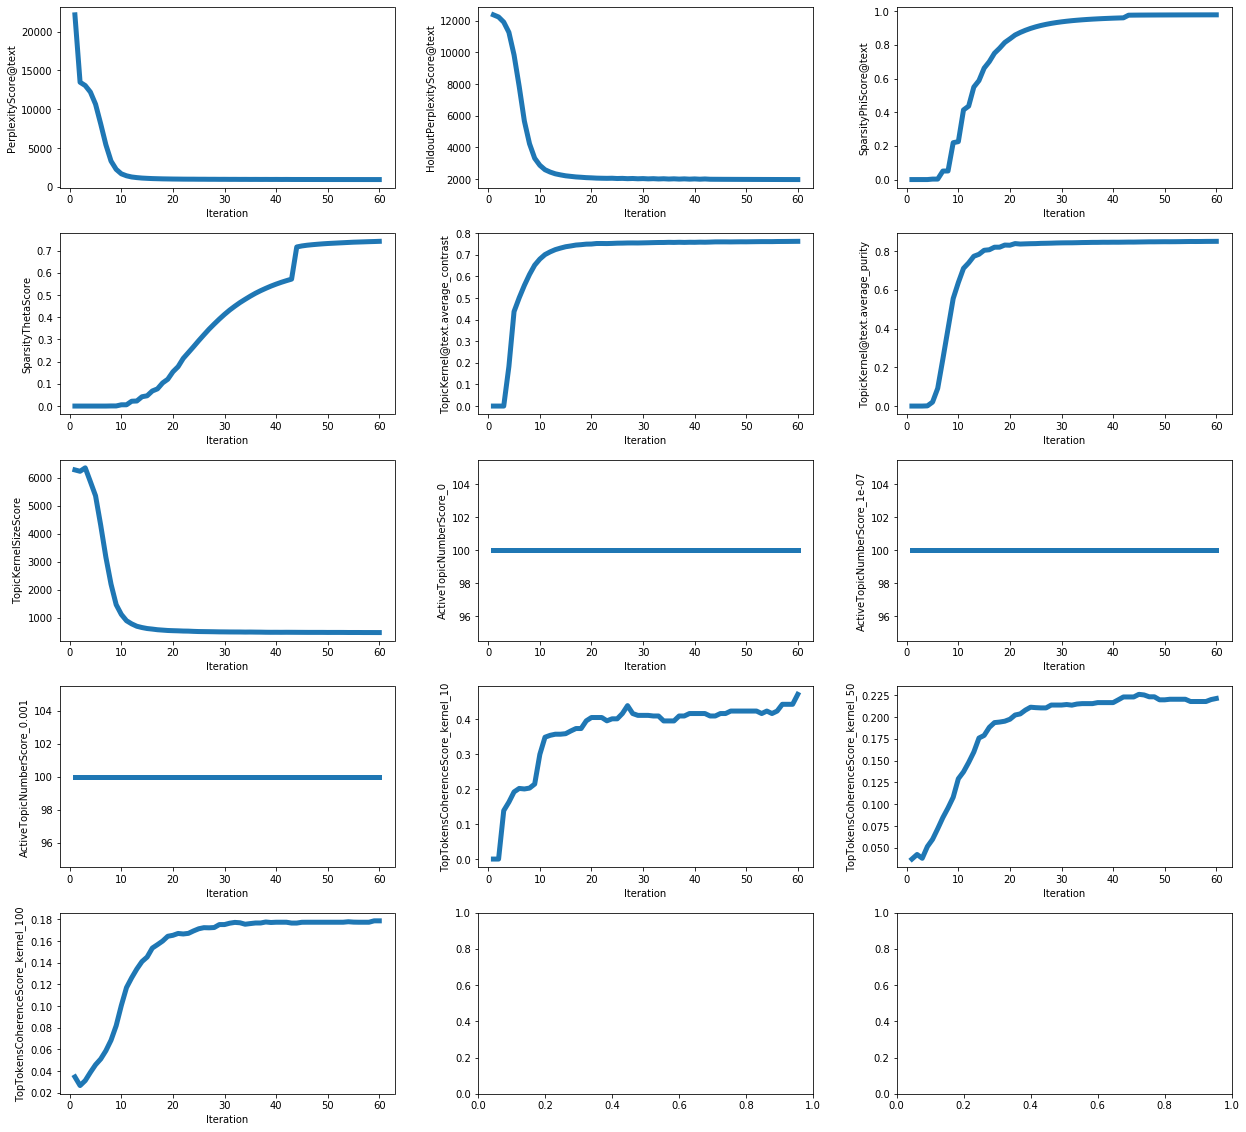

In [ ]:
draw_plots(models[0], num_cols=3)

In [ ]:
show_scores(models[0], SCORES)

PerplexityScore@text                        913.721
HoldoutPerplexityScore@text                1971.488
SparsityPhiScore@text                         0.978
SparsityThetaScore                            0.741
TopicKernel@text.average_contrast             0.762
TopicKernel@text.average_purity               0.850
TopicKernelSizeScore                        474.000
ActiveTopicNumberScore_0                    100.000
ActiveTopicNumberScore_1e-07                100.000
ActiveTopicNumberScore_0.001                100.000
TopTokensCoherenceScore_kernel_10             0.472
TopTokensCoherenceScore_kernel_50             0.221
TopTokensCoherenceScore_kernel_100            0.179


In [ ]:
del topic_model

del decorrelation_tau_converter
del selection_tau_converter
del sparsing_tau_converter

del cube_parameters
del cube

### Sophisticated. Alternating Order & Changing Parameters<a id="sophisticated-alternating-and-changing"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Here we will try to create a training procedure similar to the one described in the paper  
[Additive Regularization of Topic Models for Topic Selection and Sparse Factorization](https://userpages.umbc.edu/~kogan/teaching/m710/15fall/papers/Voron15slds.pdf) by K.&nbsp;Vorontsov, A.&nbsp;Potapenko, and A.&nbsp;Plavin

Order as well as regularizer parameters are going to be changed here.

In [ ]:
def decorrelation_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    end_iteration = 2 * NUM_CUBE_ITERATIONS

    if cur_iter <= end_iteration:
        if cur_iter % 2 == 1:
            return max(1, cur_iter / NUM_CUBE_ITERATIONS) * DECORRELATION_TAU
        else:
            return 0.0
    else:
        return 0.0

def selection_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    start_iteration = NUM_CUBE_ITERATIONS // 4  # after some time since decorrelation started
    end_iteration = 2 * NUM_CUBE_ITERATIONS + 3 * NUM_CUBE_ITERATIONS // 4

    if cur_iter <= start_iteration:
        return 0.0
    elif cur_iter <= end_iteration:
        if cur_iter % 2 == 1:
            return 0.0
        else:
            return max(1, (cur_iter - start_iteration) / NUM_CUBE_ITERATIONS) * SELECTION_TAU
    else:
        return 0.0

def sparsing_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    start_iteration = 2 * NUM_CUBE_ITERATIONS

    if cur_iter > start_iteration: 
        return max(1, (cur_iter - start_iteration) / NUM_CUBE_ITERATIONS) * SPARSING_TAU
    else:
        return 0.0

In [ ]:
cube_parameters = [
    {
        'reg_name': DECORRELATE_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MODALITY,
        'tau_converter': decorrelation_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SELECT_TOPICS,
        'score_to_track': PERPLEXITY_SCORE + MODALITY,
        'tau_converter': selection_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SPARSE_PHI_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MODALITY,
        'tau_converter': sparsing_tau_converter,
        'user_value_grid': [0]
    }
]

cube = RegularizationControllerCube(
    num_iter=3 * NUM_CUBE_ITERATIONS,
    parameters=cube_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [ ]:
enable_hide_warnings()

topic_model = initialize_topic_model()

To toggle on/off output_stderr, click here .

In [ ]:
%%time

models = cube(topic_model, dataset)

CPU times: user 11min 2s, sys: 31.1 s, total: 11min 33s
Wall time: 9min 25s


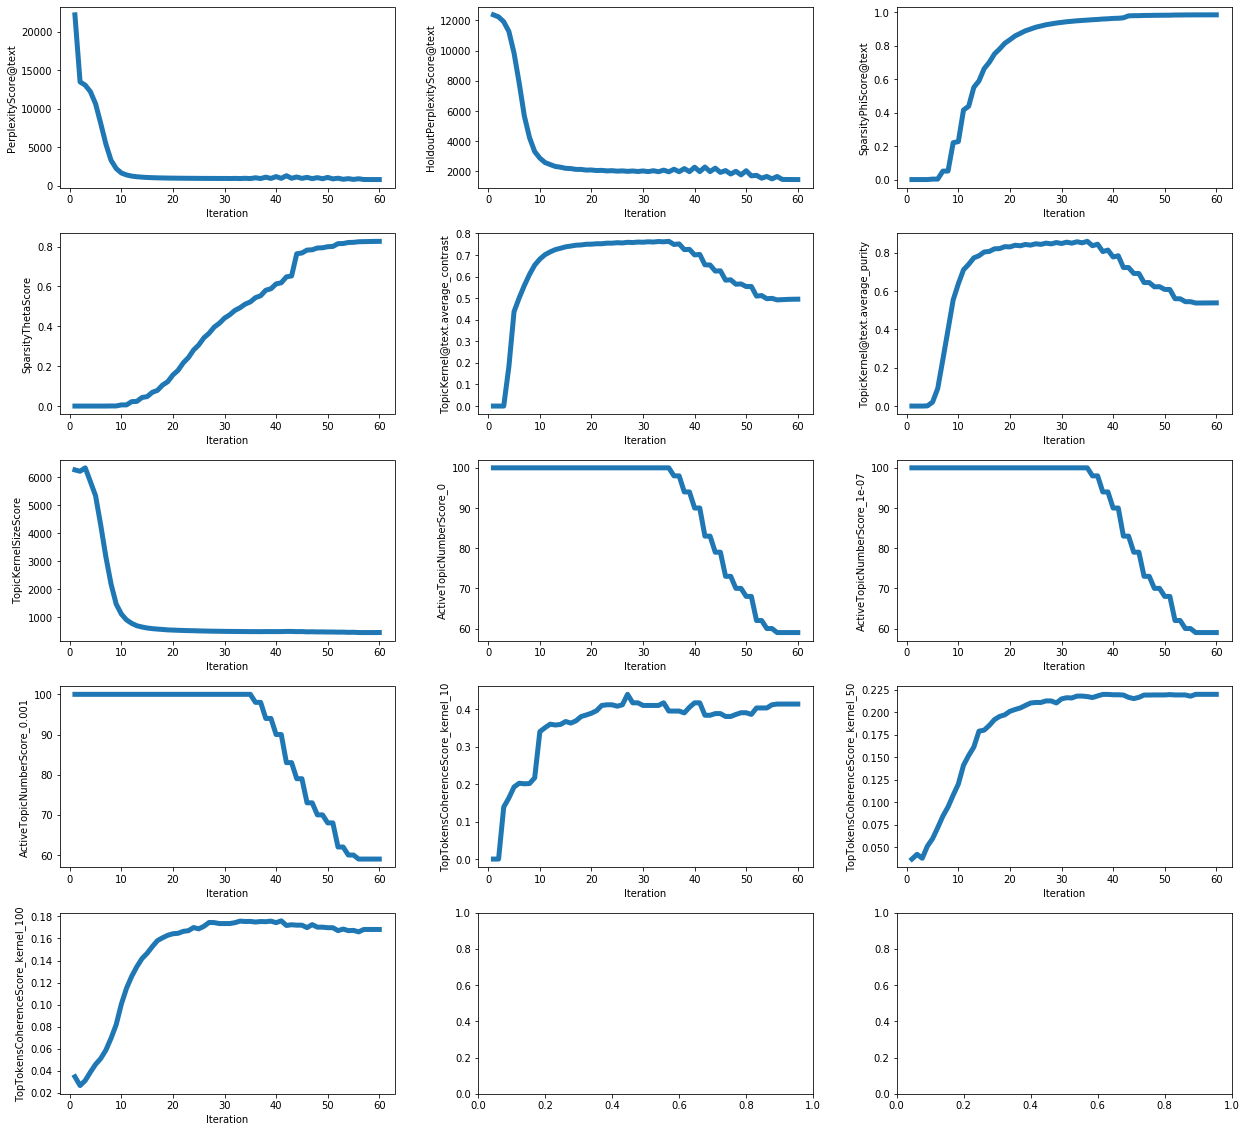

In [ ]:
draw_plots(models[0], num_cols=3)

In [ ]:
show_scores(models[0], SCORES)

PerplexityScore@text                        800.836
HoldoutPerplexityScore@text                1463.886
SparsityPhiScore@text                         0.985
SparsityThetaScore                            0.826
TopicKernel@text.average_contrast             0.495
TopicKernel@text.average_purity               0.539
TopicKernelSizeScore                        451.000
ActiveTopicNumberScore_0                     59.000
ActiveTopicNumberScore_1e-07                 59.000
ActiveTopicNumberScore_0.001                 59.000
TopTokensCoherenceScore_kernel_10             0.414
TopTokensCoherenceScore_kernel_50             0.220
TopTokensCoherenceScore_kernel_100            0.168


In [ ]:
del topic_model

del decorrelation_tau_converter
del selection_tau_converter
del sparsing_tau_converter

del cube_parameters
del cube

# Results<a id="results"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Let's compare the results which we got using different regularizer combinations.
Below in table <em>D</em> stands for Decorrelation, <em>TS</em> for Topic Selection, <em>ATN</em> for Active Topic Number, <em>S</em> for Sophisticated, <em>OAA</em> for One After Another, <em>CP</em> for Changing Parameters, <em>AO</em> for Alternating Order

| Method | Perplexity | Holdout Perplexity | ATN (0) | Coherence (10) | Coherence (50) | Coherence (100) |
| --- | --- | --- | --- | --- | --- | --- |
| D, TS | 916 | 1965 | 99 | 0.46 | 0.23 | 0.18 |
| TS, D | 1010 | 2140 | 87 | 0.38 | 0.21 | 0.17 |
| D + TS (short) | 1016 | 2134 | 88 | 0.41 | 0.20 | 0.17 |
| D + TS (long) | 1020 | 2151 | 85 | 0.40 | 0.20 | 0.17 |
| S (OAA) | 915 | 1964 | 99 | 0.43 | 0.23 | 0.18 |
| S (CP) | 917 | 1974 | 100 | 0.39 | 0.22 | 0.18 |
| S (AO) | 914 | 1971 | 100 | **0.47** | 0.22 | 0.18 |
| S (AO + CP) | **800** | **1463** | **59** | 0.41 | 0.22 | 0.17 |

As one can see, the last Sophisticated variant AO + CP led to the lowest perplexities.
Just no less importantly, many topics were thrown away, and, as a result, we got the closest to optimal 20 number of topics: 59.
It indeed seems notable: model with smaller number of topics showed perplexity significantly lower than models with higher number of topics.
And the coherence, although not the maximum, is still high.

# Conclusion<a id="conclusion"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Finding the optimal, *true* number of topics in the text collection is an ulsolved task.
Here we considered one approach using implemented in BigARTM regularizer (see [paper](https://userpages.umbc.edu/~kogan/teaching/m710/15fall/papers/Voron15slds.pdf)).
However, there may be many approaches to handle the task.
For example, one may vary the number of topics and choose such a number which gives the highest score (Perplexity for example).
There are also more interesting ideas, such as applying such notion as *entropy* (see [paper](https://www.researchgate.net/profile/Sergei_Koltsov2/publication/337427975_5th_International_Electronic_Conference_on_Entropy_and_Its_Applications_Fast_tuning_of_topic_models_an_application_of_Renyi_entropy_and_renormalization_theory/links/5dd6d6bf458515dc2f41e248/5th-International-Electronic-Conference-on-Entropy-and-Its-Applications-Fast-tuning-of-topic-models-an-application-of-Renyi-entropy-and-renormalization-theory.pdf))

On the other hand, in general it’s not entirely clear whether it is possible to talk about such a concept as the *optimal number of topics*.
Topic in human understanding is not a strictly defined concept.
Moreover, each topic may have parent and child ones, that is there may be different optimal numbers of topics depending on what level of topic hierarchy we are interested in.

Nevertheless, it is also wrong to choose the number of topics absolutely at random.
One should have at least some prior knowledge about the dataset.

TopicNet library provides convenient ways of combining different regularizers (including the one which helps to select the number of topics).
Changing order of regularizers, varying regularizer parameters — all these things can relatively easily be implemented with TopicNet.
It gives opportunity to create complex learning strategies and get better topic models.

P.S.  
If you uncomment and execute the code in the cell below, it will delete the working directory with all the created files in it

In [ ]:
# shutil.rmtree(working_directory)

# Appendix. Non-Topic Modeling Baseline<a id="appendix1-non-topic"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In this appendix there is just an example of how one can try to determine the topic number without topic modeling at all, using only several tools from Scikit-learn.
Let us call this approach "Scikit-learn pipeline" based.

In [ ]:
import sys

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN

from munkres import Munkres

In [ ]:
%%time

count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(good_train_document_texts)

print(X_train_counts.shape)

(7847, 22772)
CPU times: user 97 ms, sys: 103 ms, total: 200 ms
Wall time: 163 ms


In [ ]:
%%time

tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

print(X_train_tfidf.shape)

(7847, 22772)
CPU times: user 3.13 ms, sys: 11.2 ms, total: 14.4 ms
Wall time: 10.4 ms


In [ ]:
%%time

# Maybe also worth trying sklearn.manifold.TSNE, but it is much slower

truncated_svd_transformer = TruncatedSVD(n_components=1000)
X_train_truncated = truncated_svd_transformer.fit_transform(X_train_tfidf)

print(X_train_truncated.shape)

(7847, 1000)
CPU times: user 1min 56s, sys: 0 ns, total: 1min 56s
Wall time: 10.9 s


In [ ]:
def compute_clusters(min_samples, eps=0.5):
    dbscan_clusterizer = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    dbscan_clusterizer.fit(X_train_truncated)

    return dbscan_clusterizer.labels_

In [ ]:
%%time

labels = compute_clusters(min_samples=6)

CPU times: user 13.7 s, sys: 21.8 ms, total: 13.7 s
Wall time: 798 ms


Number of documents

In [ ]:
len(good_train_document_indices)

7847

Number of labels (should be the same as the number of documents)

In [ ]:
len(labels)

7847

Number of clusters

In [ ]:
len(set(labels))

120

Number of documents the algorithm failed to assign a topic to 

In [ ]:
len([c for c in labels if c == -1])

1853

In [ ]:
BAD_CLUSTER = -1
NUM_ORIGINAL_TOPICS = len(set(train_dataset.target))

In [ ]:
NUM_ORIGINAL_TOPICS

20

Now we need to match clusters to original topics: which cluster corresponds to which topic.
Below we calculate `hits_matrix`: how many common documents have original topics and clusters.

In [ ]:
def compute_hits_matrix(labels, document_indices, true_labels):
    candidate_topics = set(labels).difference(set([BAD_CLUSTER]))

    hits_matrix = np.zeros((len(candidate_topics), NUM_ORIGINAL_TOPICS))

    for candidate_topic_index, candidate_topic in enumerate(sorted(candidate_topics)):
        for true_topic_index, true_topic in enumerate(sorted(set(true_labels))):
            docs_set_a = set([
                i for i in document_indices if true_labels[i] == true_topic
            ])
            docs_set_b = set([
                i for j, i in enumerate(document_indices) if labels[j] == candidate_topic
            ])

            num_hits = len(docs_set_a.intersection(docs_set_b))

            hits_matrix[candidate_topic_index, true_topic_index] = num_hits
    
    return hits_matrix

In [ ]:
hits_matrix = compute_hits_matrix(labels, good_train_document_indices, train_dataset.target)

And now, using the [Hungarian algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm), we are going to find the matching.

* http://software.clapper.org/munkres/#calculating-profit-rather-than-cost

In [ ]:
def compute_cost_matrix(hits_matrix):
    cost_matrix = []

    for row in hits_matrix:
        cost_row = []

        for col in row:
            cost_row += [sys.maxsize - col]

        cost_matrix += [cost_row]
    
    return cost_matrix


def compute_total_hits_number(hits_matrix):
    cost_matrix = compute_cost_matrix(hits_matrix)
    
    m = Munkres()
    indexes = m.compute(cost_matrix)

    total_hits_num = 0

    for row, column in indexes:
        num_hits = hits_matrix[row][column]
        total_hits_num += num_hits

    return total_hits_num

In [ ]:
hits_number = compute_total_hits_number(hits_matrix)

print(f'Total number of correctly thematized documents = {hits_number}')

Total number of correctly thematized documents = 215.0


Seems not very good...
Let's try to vary the parameters of DBSCAN algorithm a little bit.

In [ ]:
%%time

hits_numbers = dict()
num_topics = dict()

max_num_min_samples = 25
nums_min_samples = list(range(1, max_num_min_samples + 1))

for num_min_samples in nums_min_samples:
    if num_min_samples < max_num_min_samples:
        end = ', '
    else:
        end = '\n'

    print(f'{num_min_samples}/{max_num_min_samples}', end=end)

    labels = compute_clusters(min_samples=num_min_samples)
    
    candidate_topics = set(labels).difference(set([BAD_CLUSTER]))
    
    if len(candidate_topics) == 0:
        hits_numbers[num_min_samples] = 0
        num_topics[num_min_samples] = 0
        
        continue

    hits_matrix = compute_hits_matrix(labels, good_train_document_indices, train_dataset.target)
    hits_number = compute_total_hits_number(hits_matrix)

    hits_numbers[num_min_samples] = hits_number
    num_topics[num_min_samples] = len(candidate_topics)

1/25, 2/25, 3/25, 4/25, 5/25, 6/25, 7/25, 8/25, 9/25, 10/25, 11/25, 12/25, 13/25, 14/25, 15/25, 16/25, 17/25, 18/25, 19/25, 20/25, 21/25, 22/25, 23/25, 24/25, 25/25
CPU times: user 9min 2s, sys: 7.81 s, total: 9min 10s
Wall time: 2min 27s


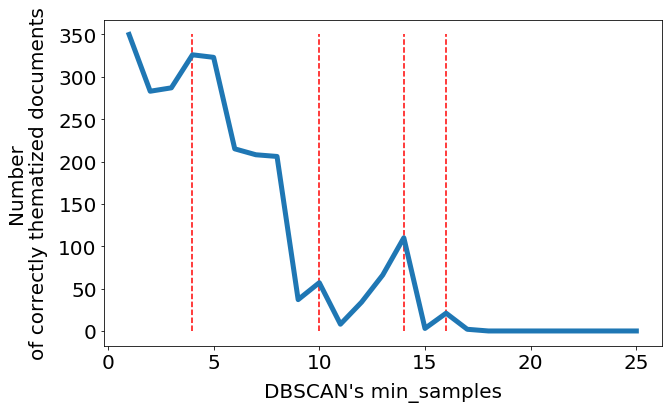

In [ ]:
plt.figure(figsize=SMALL_FIGSIZE)

x = nums_min_samples
y = [hits_numbers[num_min_samples] for num_min_samples in x]

plt.plot(x, y, lw=LINEWIDTH)

plt.vlines(4, min(y), max(y), linestyle='--', color='r')
plt.vlines(10, min(y), max(y), linestyle='--', color='r')
plt.vlines(14, min(y), max(y), linestyle='--', color='r')
plt.vlines(16, min(y), max(y), linestyle='--', color='r')

plt.xlabel('DBSCAN\'s min_samples', labelpad=LABELPAD)
plt.ylabel('Number\nof correctly thematized documents', labelpad=LABELPAD)

plt.show()

We can see several peaks on the above plot: with `min_samples = 4, 10, 14, 16`, and besides `min_samples = 4, 14` give sharper peaks.

P.S.  
If you restart the notebook or run the above cells several times, the picture will change and optimal `min_samples` will be a bit different, but there is a high probability that there still will be two main peaks: near `min_samples` equals 4 and `min_samples` equals 14.

In [ ]:
candidate_min_samples = [4, 10, 14, 16]

min_samples =  4, number of topics =  74
min_samples = 10, number of topics = 154
min_samples = 14, number of topics =  36
min_samples = 16, number of topics =  16


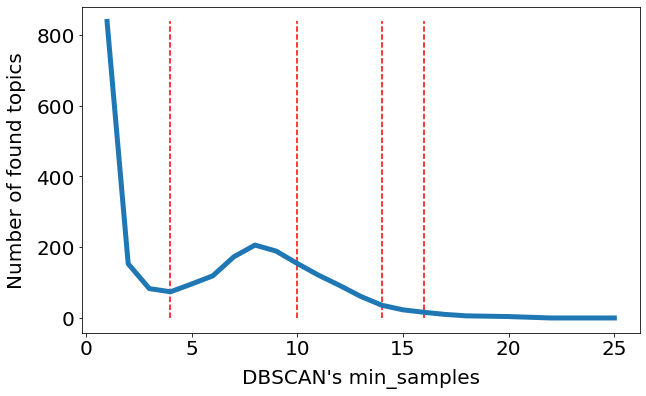

In [ ]:
plt.figure(figsize=SMALL_FIGSIZE)

x = nums_min_samples
y = [num_topics[num_min_samples] for num_min_samples in x]

plt.plot(x, y, lw=LINEWIDTH)

for min_samples in candidate_min_samples:
    plt.vlines(min_samples, min(y), max(y), linestyle='--', color='r')
    
    print(f'min_samples = {min_samples:2d}, number of topics = {y[x.index(min_samples)]:3d}')

plt.xlabel('DBSCAN\'s min_samples', labelpad=LABELPAD)
plt.ylabel('Number of found topics', labelpad=LABELPAD)

plt.show()

Thus, the number of topics according to this approach is somewhere between 16 and 154.
Two distinct points are number of topics equals 74 (with `min_samples = 4`) and 36 (with `min_samples = 14`).

For this particular dataset the result seems quite good.
However, in order to find the best way to determine the number of topics more thorough research is needed.